In [3]:
import xarray as xr
import cartopy.crs as ccrs

import math
import numpy as np

from scipy.stats import boxcox

import matplotlib.pyplot as plt

import torch

In [237]:
cp_model_rotated_pole = ccrs.RotatedPole(
    pole_longitude=177.5,
    pole_latitude=37.5
)
platecarree = ccrs.PlateCarree()


class SelectDomain:

    # Domain centres in standard latitude and longitude
    DOMAIN_CENTRES_LON_LAT = {
        "london": (-0.118092, 51.509865),
        "birmingham": (-1.898575, 52.489471),
    }

    # Domain centres in rotated pole latitude and longitude
    DOMAIN_CENTRES_RP_LONG_LAT = {
        domain_name: cp_model_rotated_pole.transform_point(
            *lon_lat, src_crs=platecarree
        )
        for domain_name, lon_lat in DOMAIN_CENTRES_LON_LAT.items()
    }

    def __init__(self, subdomain, size=64) -> None:
        self.subdomain = subdomain
        self.size = size

    def run(self, ds):

        # Find the grid square in the dataset nearest to the centre
        # Assumes dataset is in rotated pole coordinates
        centre_rp_lon_lat = self.DOMAIN_CENTRES_RP_LONG_LAT[self.subdomain]
        centre_ds = ds.sel(
            grid_longitude=360.0 + centre_rp_lon_lat[0],
            grid_latitude=centre_rp_lon_lat[1],
            method="nearest",
        )

        # Find the INDEX of the central square in the grid latitude and longitude coordinates
        centre_long_idx = np.where(
            ds.grid_longitude.values == centre_ds.grid_longitude.values
        )[0].item()
        centre_lat_idx = np.where(
            ds.grid_latitude.values == centre_ds.grid_latitude.values
        )[0].item()

        # Set how many grid squares to go up, down, left and right from the centre box
        # in order to get a box the is self.size by self.size
        radius = self.size - 1
        left_length = math.floor(radius / 2.0)
        right_length = math.ceil(radius / 2.0)
        down_length = math.floor(radius / 2.0)
        up_length = math.ceil(radius / 2.0)

        # Select only the bits of the dataset that lie in the box defined
        ds = ds.sel(
            grid_longitude=slice(
                ds.grid_longitude[centre_long_idx - left_length].values,
                ds.grid_longitude[centre_long_idx + right_length].values,
            ),
            grid_latitude=slice(
                ds.grid_latitude[centre_lat_idx - down_length].values,
                ds.grid_latitude[centre_lat_idx + up_length].values,
            ),
        )

        return ds

<xarray.Dataset>
Dimensions:                     (ensemble_member: 1, time: 720,
                                 grid_latitude: 606, grid_longitude: 484,
                                 bnds: 2)
Coordinates:
  * ensemble_member             (ensemble_member) int32 1
  * time                        (time) object 1980-12-01 00:30:00 ... 1980-12...
  * grid_latitude               (grid_latitude) float64 -4.683 -4.647 ... 8.063
  * grid_longitude              (grid_longitude) float64 353.9 354.0 ... 364.3
    ensemble_member_id          (ensemble_member) |S27 ...
    latitude                    (grid_latitude, grid_longitude) float64 ...
    longitude                   (grid_latitude, grid_longitude) float64 ...
    month_number                (time) int32 ...
    year                        (time) int32 ...
    yyyymmddhh                  (time) |S64 ...
Dimensions without coordinates: bnds
Data variables:
    pr                          (ensemble_member, time, grid_latitude, grid_longitude) float32 ...
    rotated_latitude_longitude  int32 ...
    time_bnds                   (time, bnds) object ...
    grid_latitude_bnds          (grid_latitude, bnds) float64 ...
    grid_longitude_bnds         (grid_longitude, bnds) float64 ...
Attributes: (12/15)
    collection:      land-cpm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2019-09-11T20:29:43
    domain:          uk
    frequency:       1hr
    institution:     Met Office Hadley Centre (MOHC), FitzRoy Road, Exeter, D...
    ...              ...
    resolution:      2.2km
    scenario:        rcp85
    source:          UKCP18 realisation from a set of 12 convection-permittin...
    title:           UKCP18 land projections - 2.2km convection-permitting cl...
    version:         v20190731
    Conventions:     CF-1.5

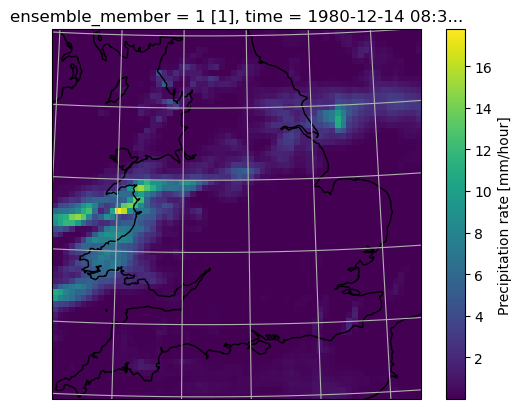

In [238]:
ds = xr.open_dataset("pr_rcp85_land-cpm_uk_2.2km_01_1hr_19801201-19801230.nc")
display(ds)

ds = ds.coarsen(grid_latitude=4, grid_longitude=4, boundary="trim").mean()
ds = SelectDomain("birmingham", size=64).run(ds)

cp_model_rotated_pole = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
ax = plt.axes(projection=cp_model_rotated_pole)
ds.isel(time=320).pr.plot(ax = ax, x = 'longitude', y = 'latitude', transform = ccrs.PlateCarree())
ax.gridlines()
ax.coastlines()
plt.show()

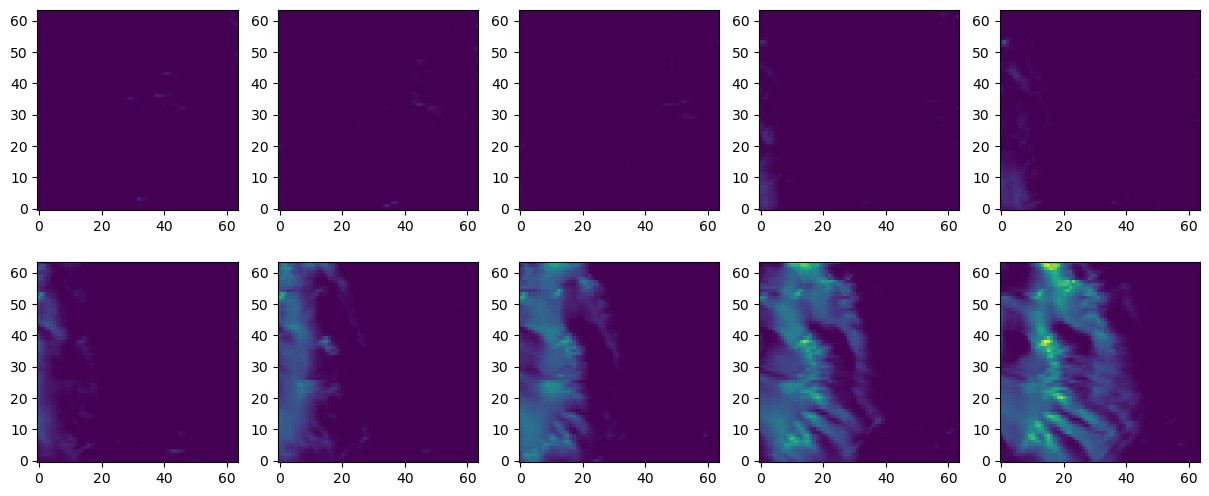

min: 0.0, max: 7.567968368530273, mean: 0.29529401659965515


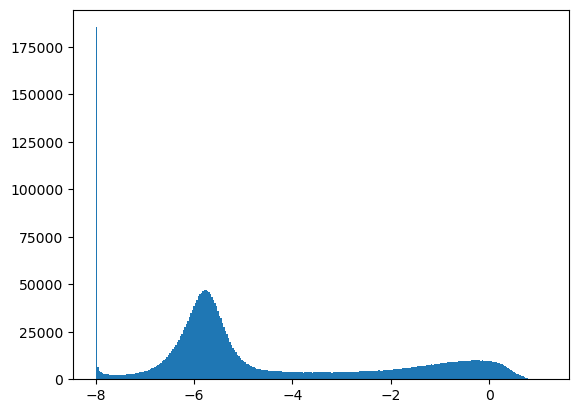

In [77]:
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_19801201-19801230.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20660501-20660530.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20801101-20801130.nc")

ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20800201-20800230.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20800301-20800330.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20800401-20800430.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20800501-20800530.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20800601-20800630.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20800701-20800730.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20800801-20800830.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20800901-20800930.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20801001-20801030.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20801101-20801130.nc")

index = 710
pr = ds.isel(time = slice(index, index + 10)).pr.values[0]

fig, axs = plt.subplots(2, 5, figsize = (15, 6))
for i in range(10):
    ax = axs.flat[i]
    frame = pr[i]
    ax.imshow(frame, origin = "lower", vmin = pr.min(), vmax = pr.max())
plt.show()

print(f"min: {pr.min()}, max: {pr.max()}, mean: {pr.mean()}")


Example 0:
min: 0.0, max: 18.57134437561035
mean: 0.22759023308753967
torch.Size([10, 64, 64])


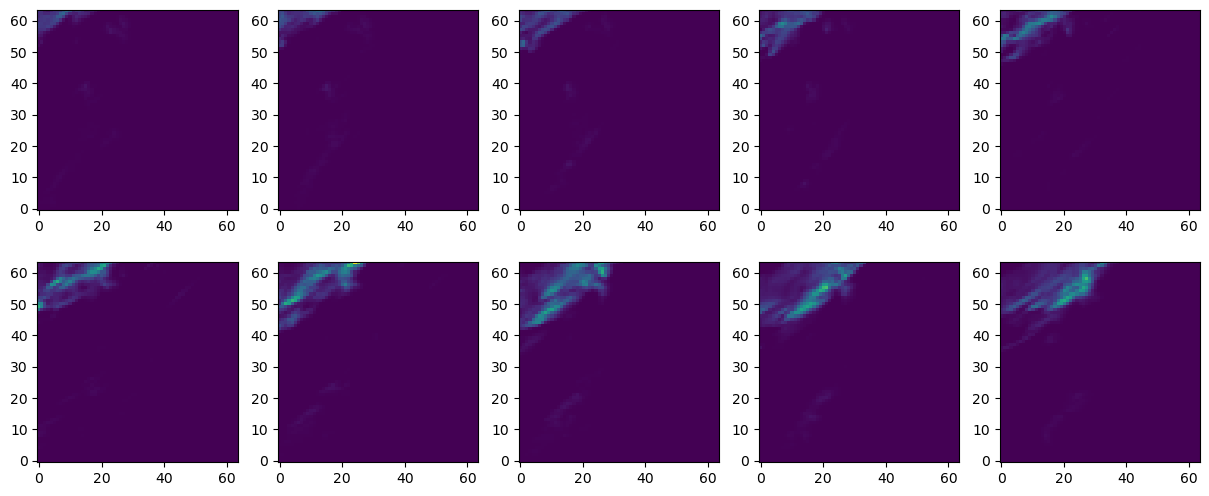

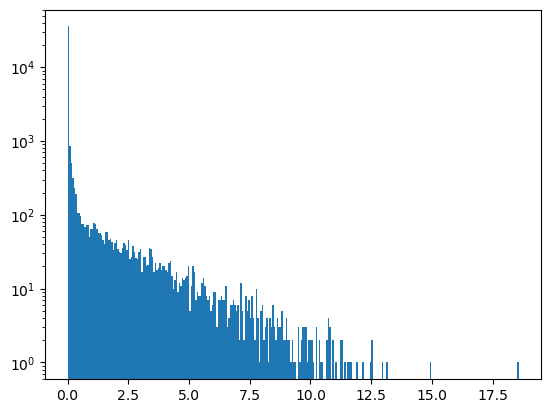


Example 1:
min: 0.0, max: 1.2101480024284683e-05
mean: 2.1214809464709106e-07
torch.Size([10, 64, 64])


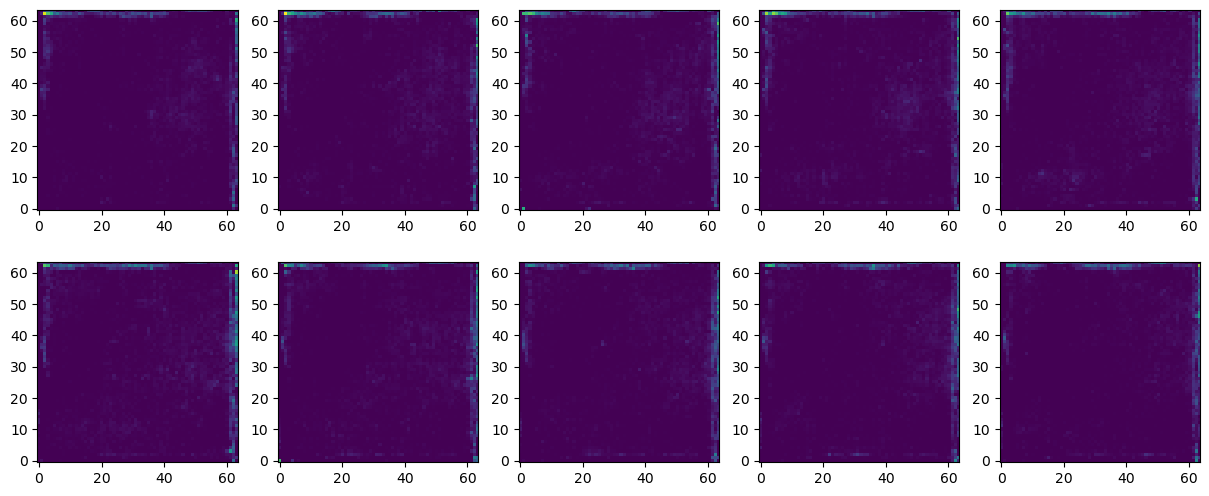

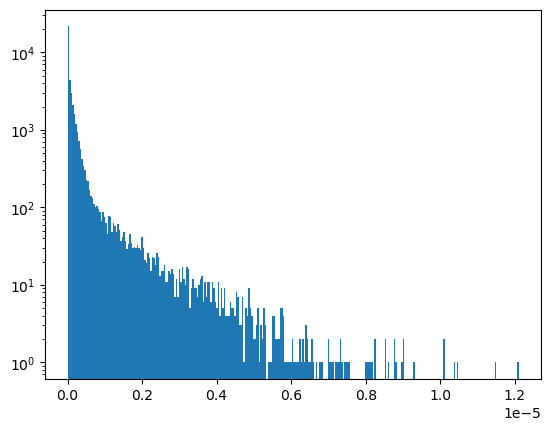


Example 2:
min: 9.271761882700957e-06, max: 6.024811267852783
mean: 0.12116382271051407
torch.Size([10, 64, 64])


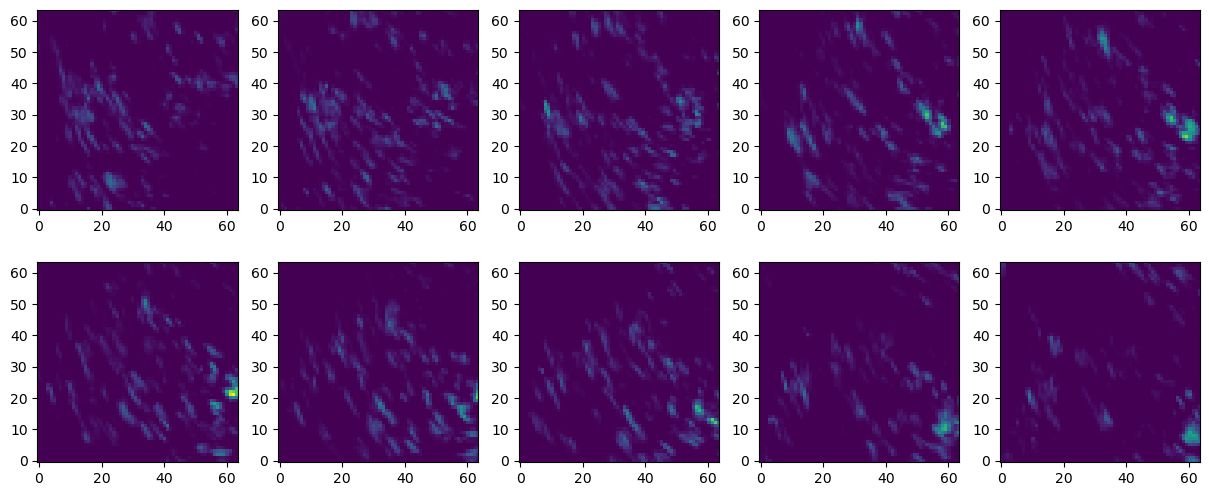

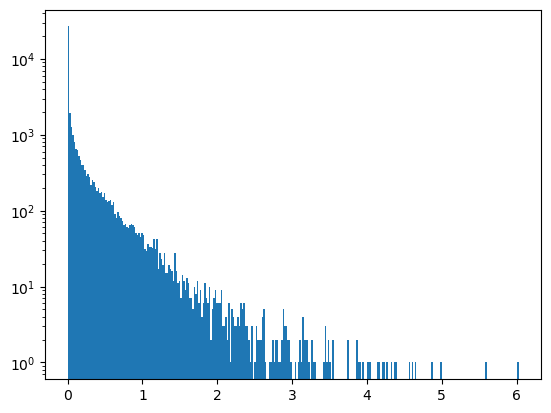


Example 3:
min: 0.0, max: 3.643644094467163
mean: 0.002988971769809723
torch.Size([10, 64, 64])


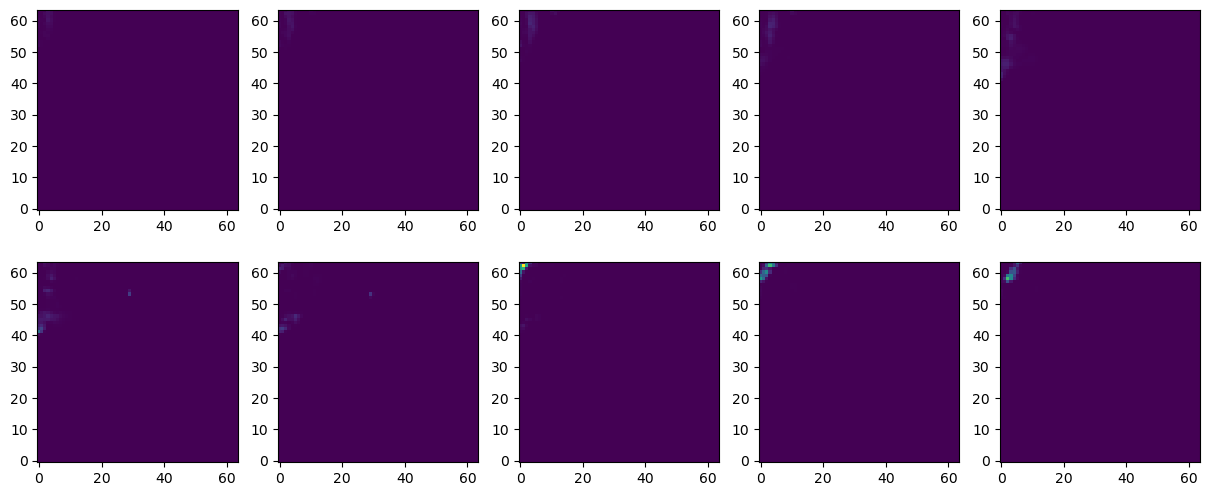

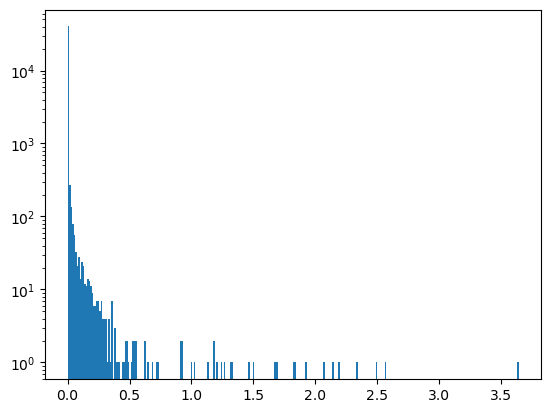


Example 4:
min: 0.0, max: 0.7096226215362549
mean: 0.0002600323932711035
torch.Size([10, 64, 64])


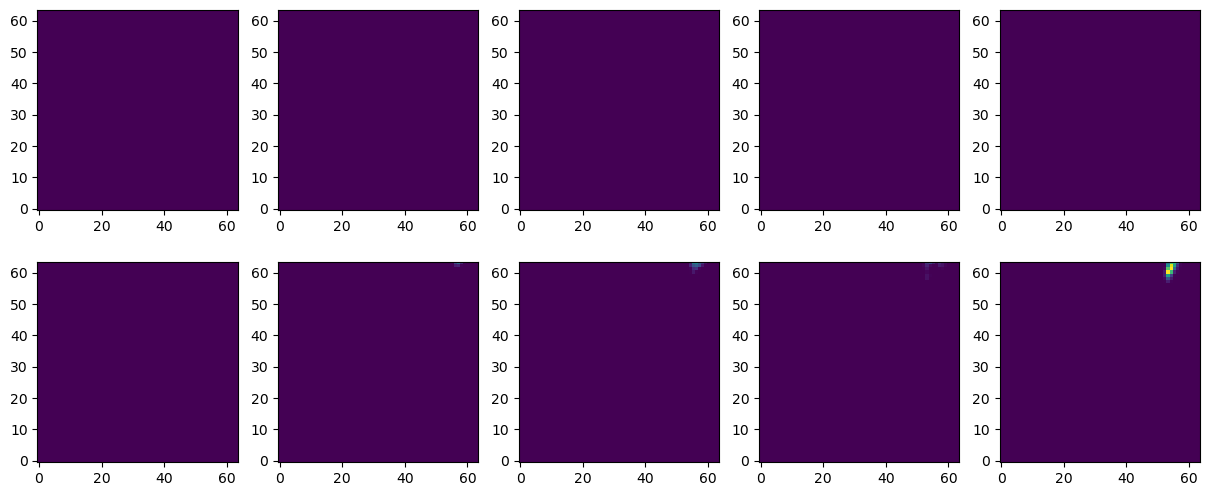

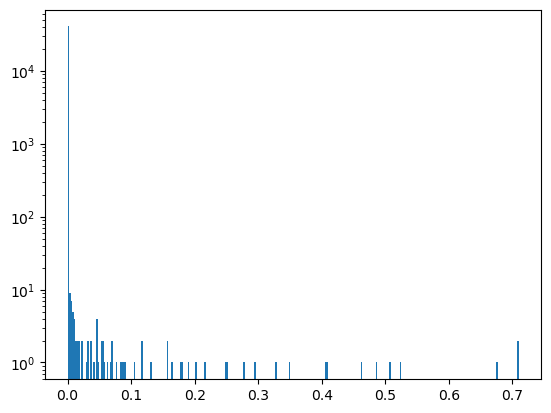


Example 5:
min: 0.0, max: 6.731106281280518
mean: 0.022582506760954857
torch.Size([10, 64, 64])


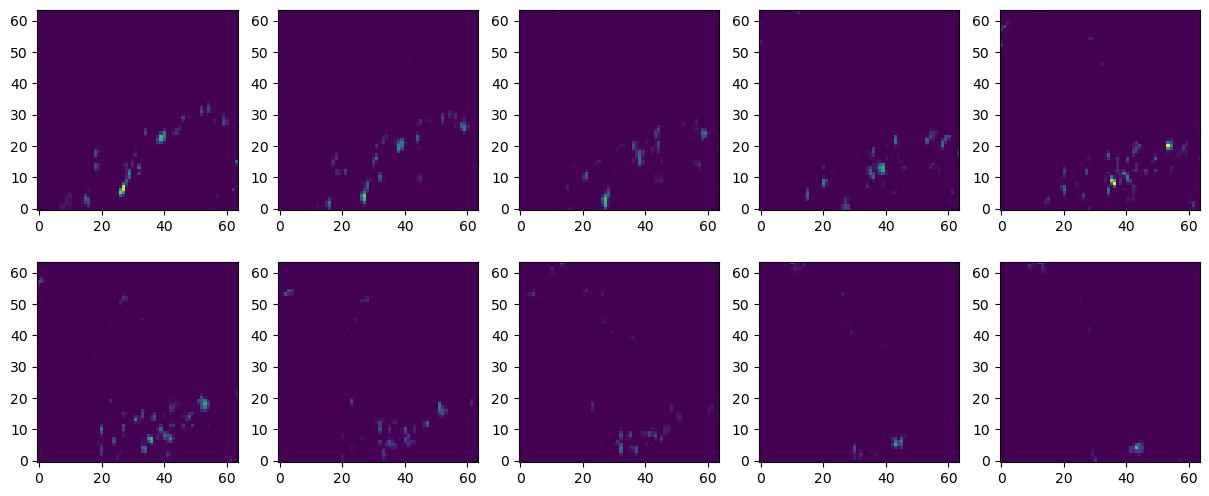

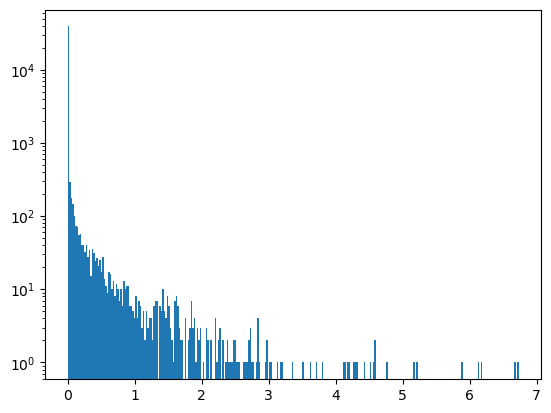


Example 6:
min: 0.0, max: 8.695633888244629
mean: 0.11503927409648895
torch.Size([10, 64, 64])


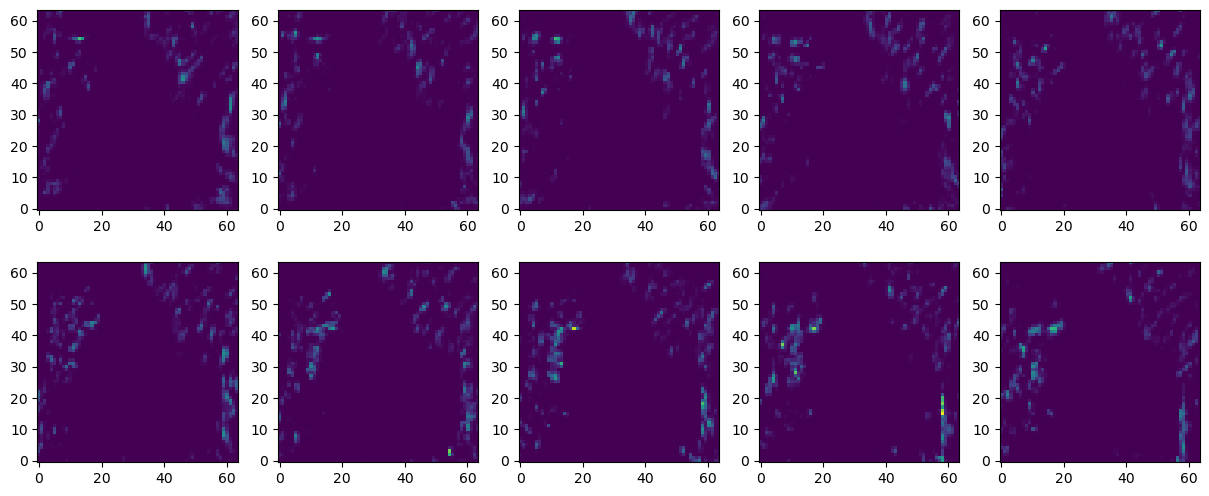

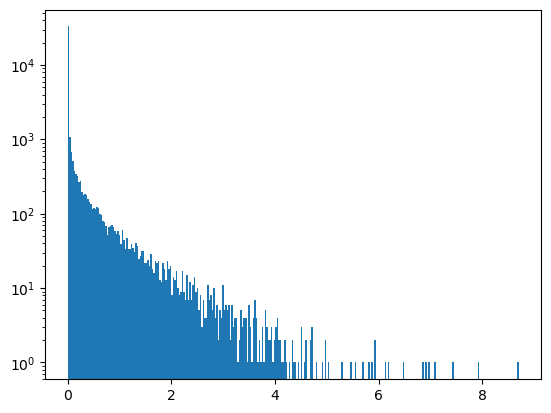


Example 7:
min: 0.0, max: 13.516768455505371
mean: 0.07046676427125931
torch.Size([10, 64, 64])


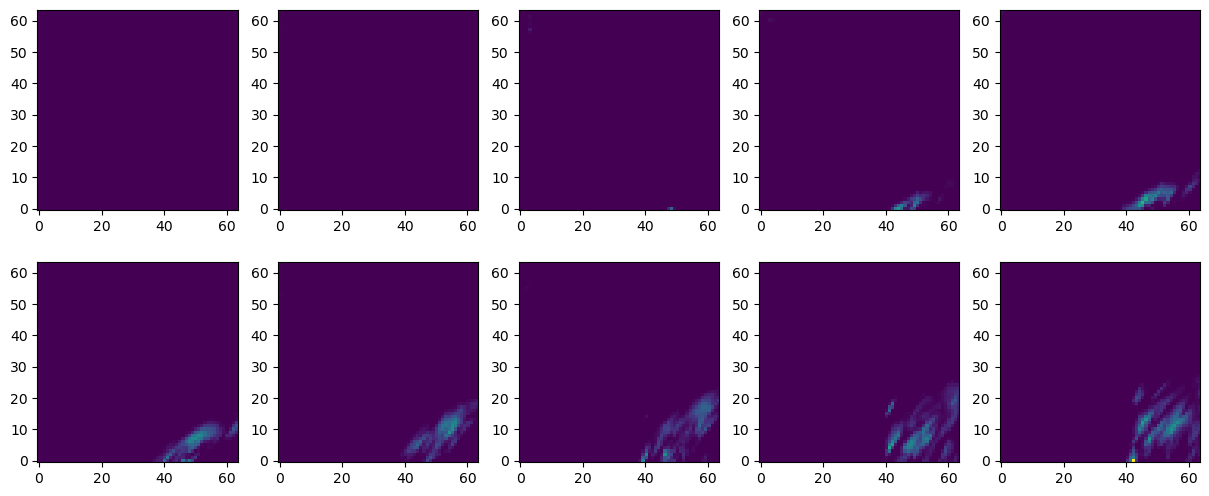

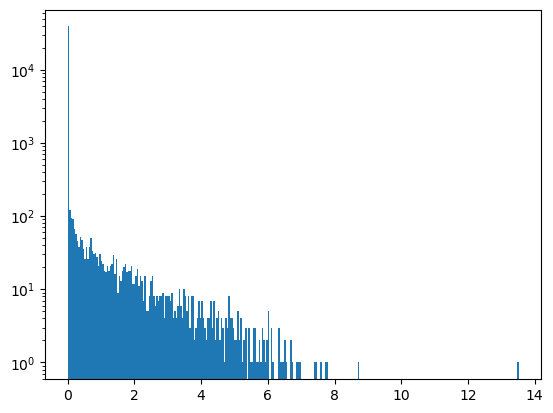


Example 8:
min: 0.0, max: 7.604403972625732
mean: 0.128696471452713
torch.Size([10, 64, 64])


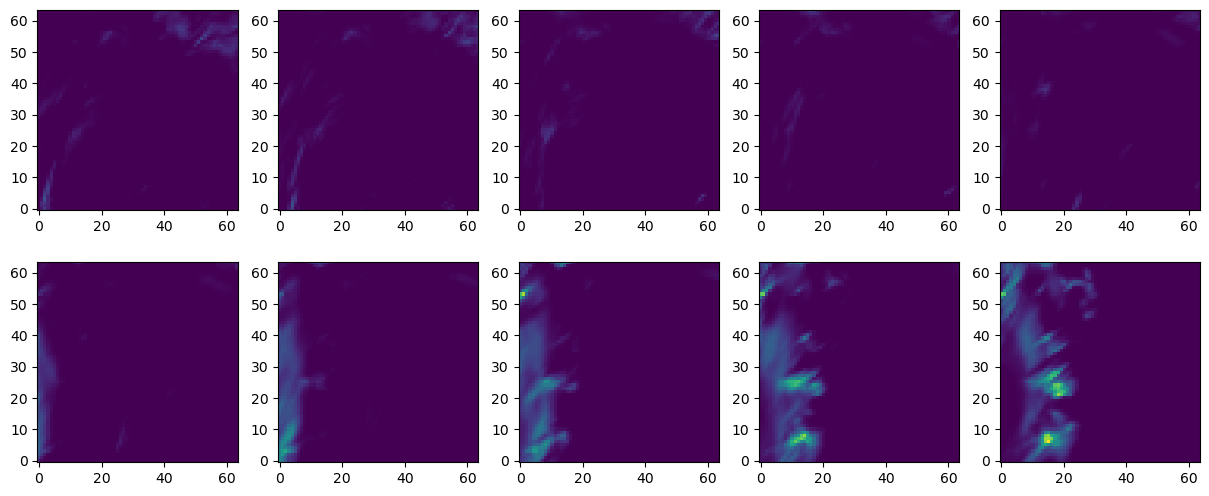

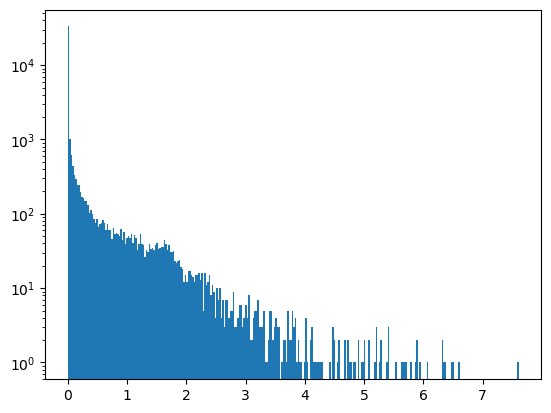


Example 9:
min: 3.280461169197224e-05, max: 0.00046797076356597245
mean: 6.867592310300097e-05
torch.Size([10, 64, 64])


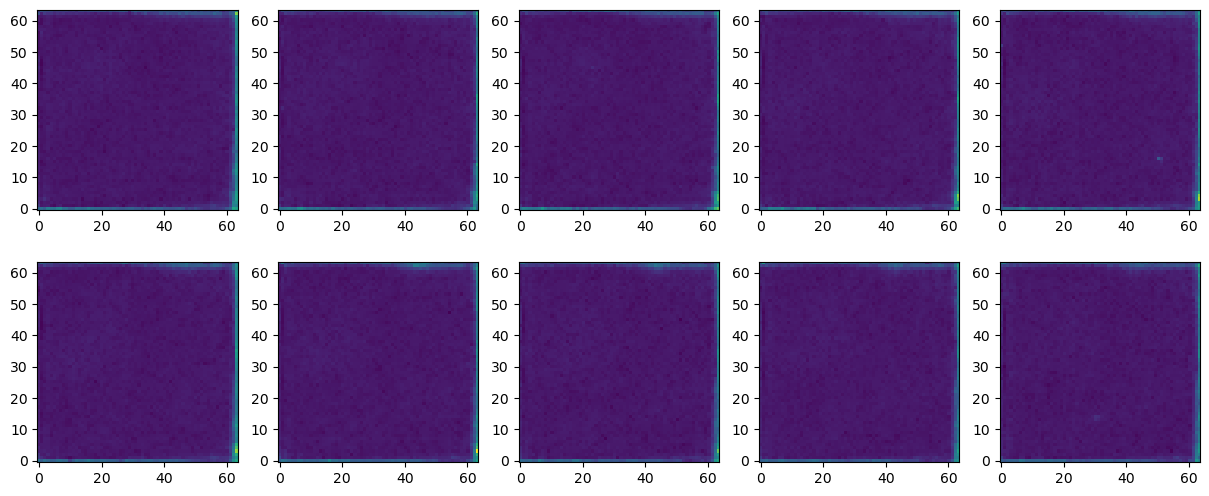

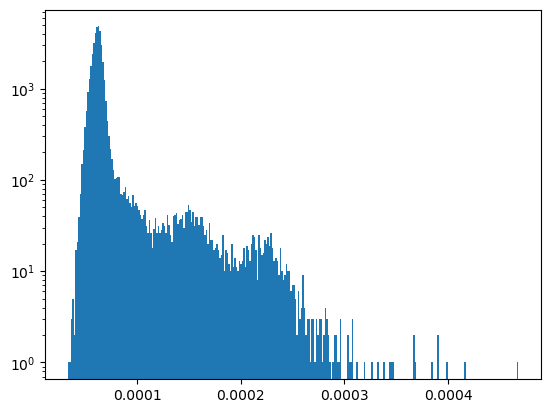


Example 10:
min: 0.0, max: 9.91788387298584
mean: 0.12606175243854523
torch.Size([10, 64, 64])


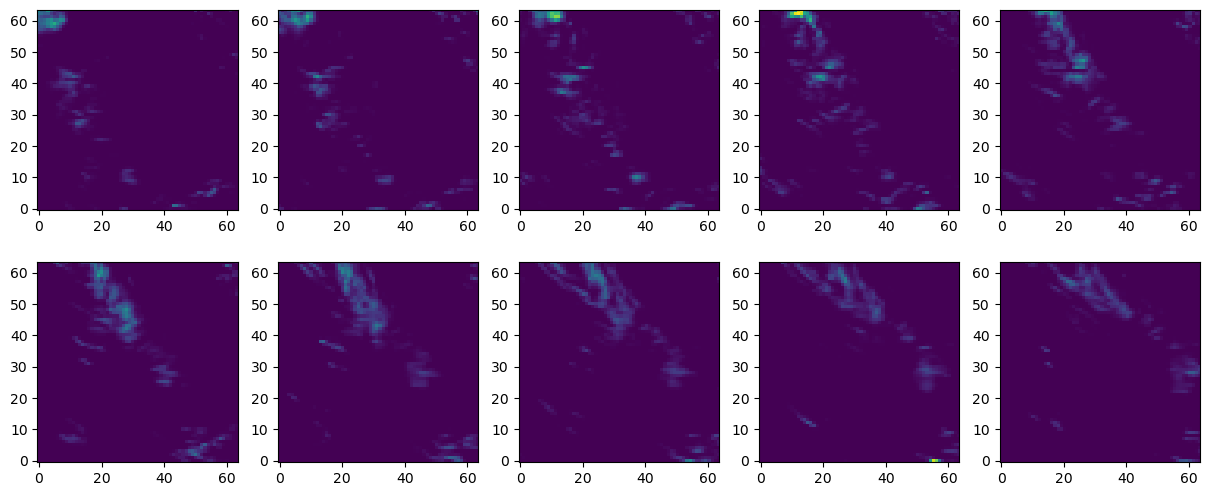

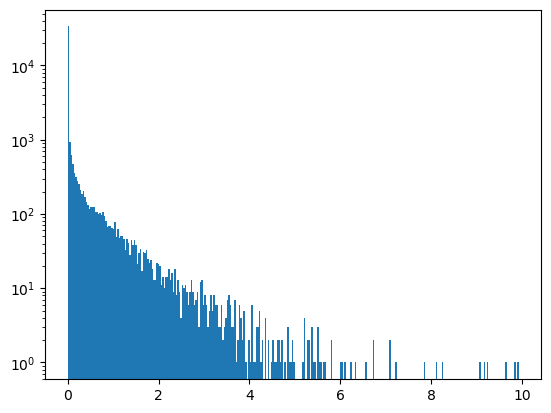


Example 11:
min: 0.0, max: 3.8606152534484863
mean: 0.05906468629837036
torch.Size([10, 64, 64])


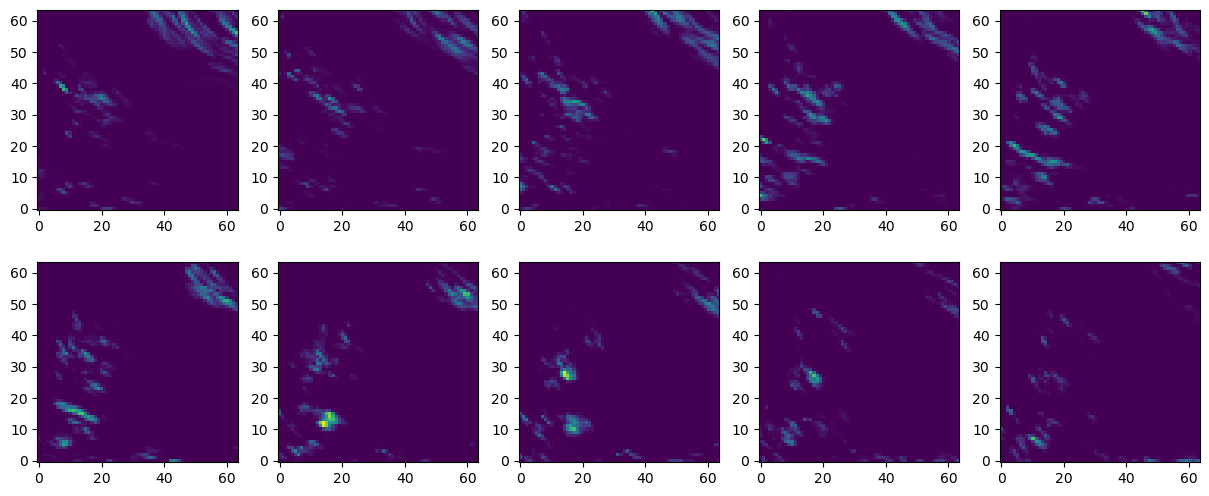

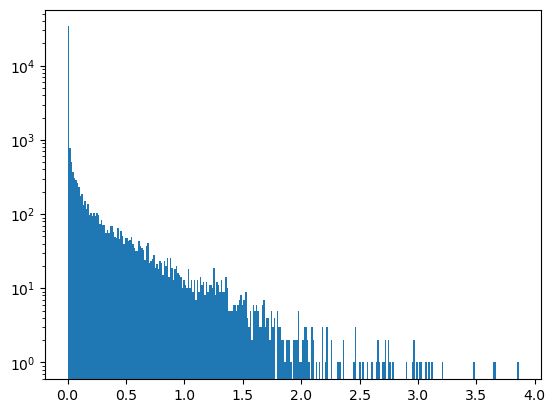


Example 12:
min: 0.0, max: 2.8931186199188232
mean: 0.011433501727879047
torch.Size([10, 64, 64])


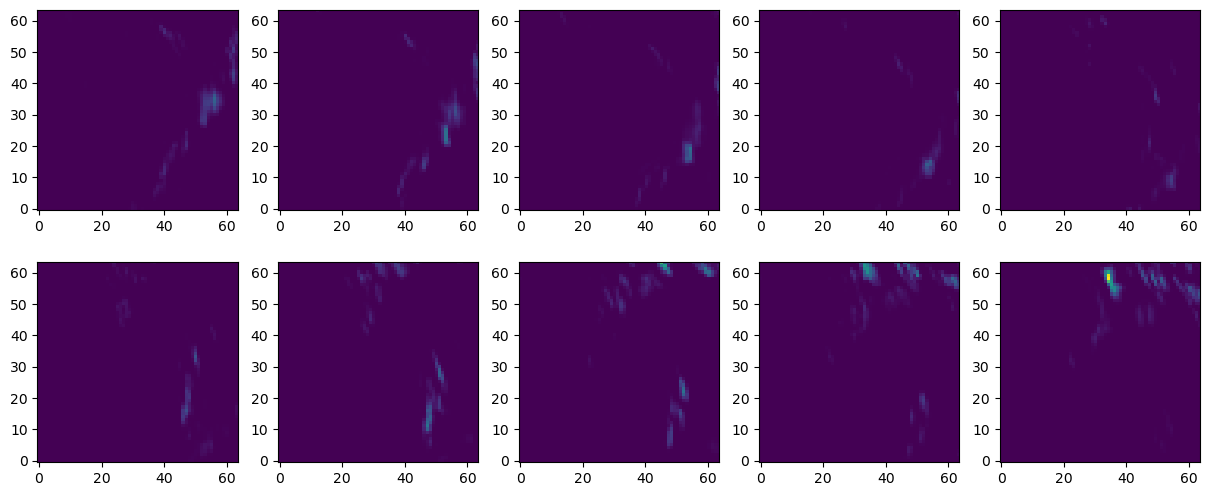

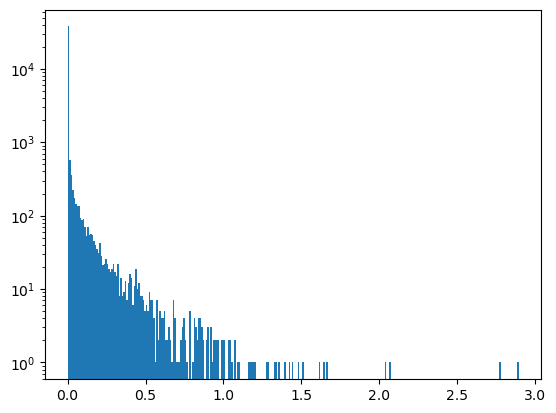


Example 13:
min: 0.0, max: 4.529445648193359
mean: 0.11865218728780746
torch.Size([10, 64, 64])


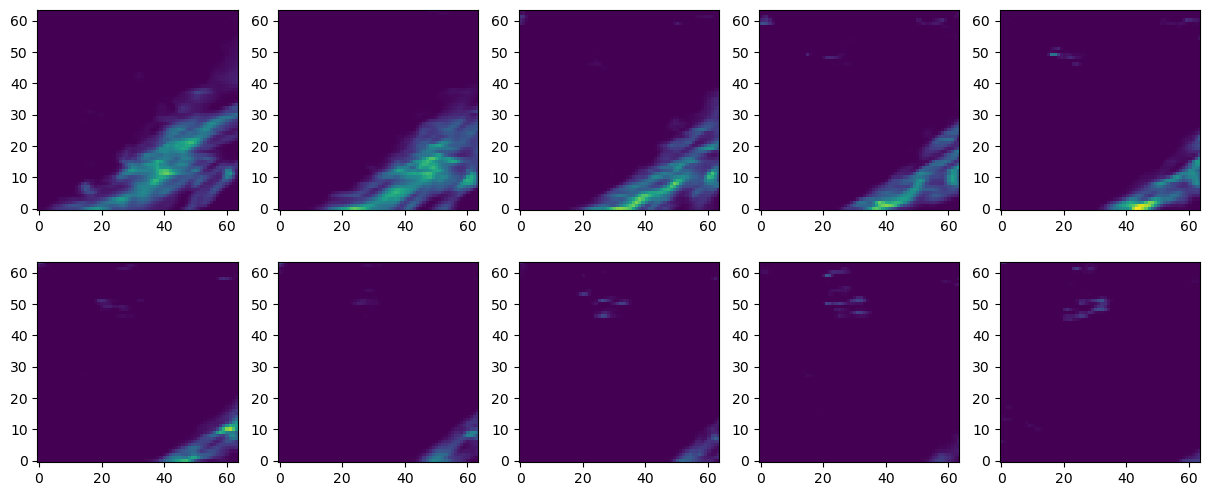

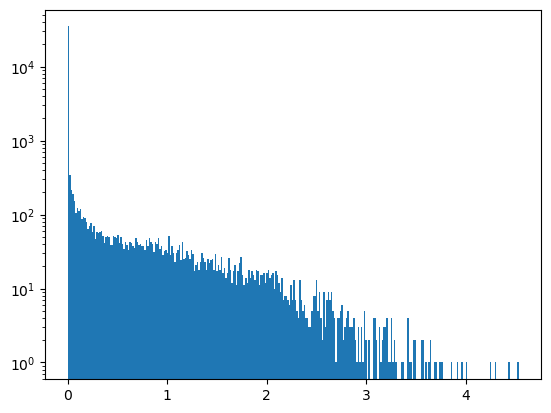


Example 14:
min: 0.0, max: 4.584881782531738
mean: 0.06450202316045761
torch.Size([10, 64, 64])


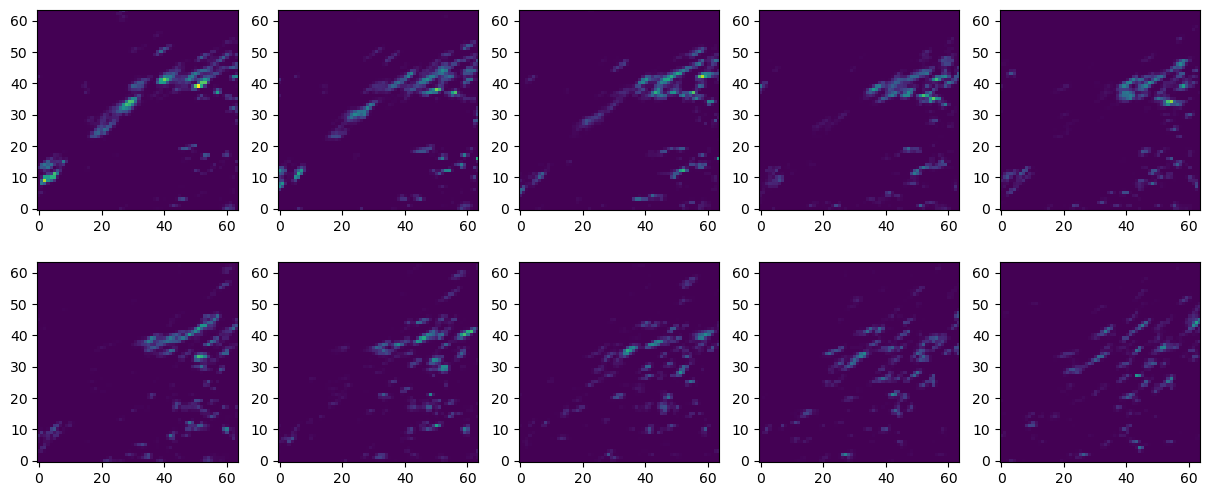

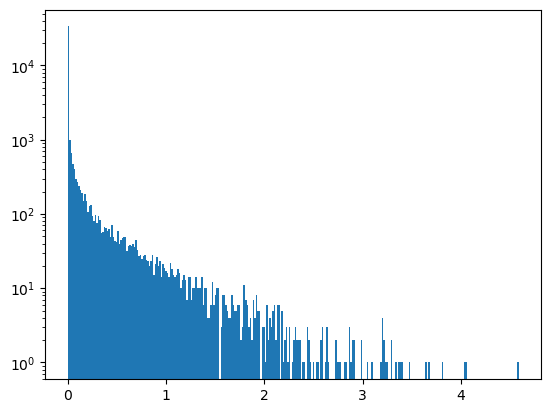


Example 15:
min: 0.0, max: 4.3101067543029785
mean: 0.011775562539696693
torch.Size([10, 64, 64])


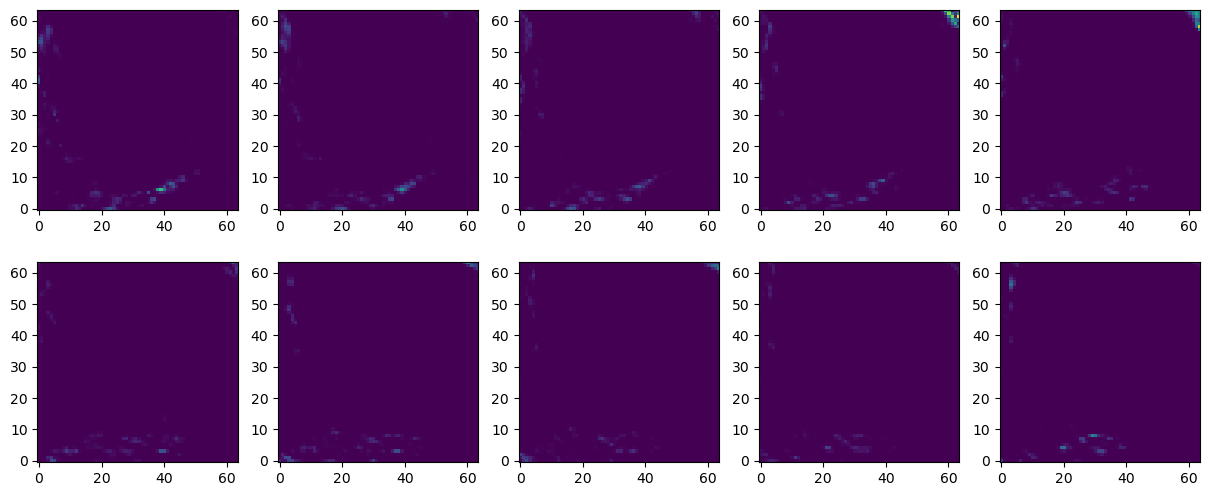

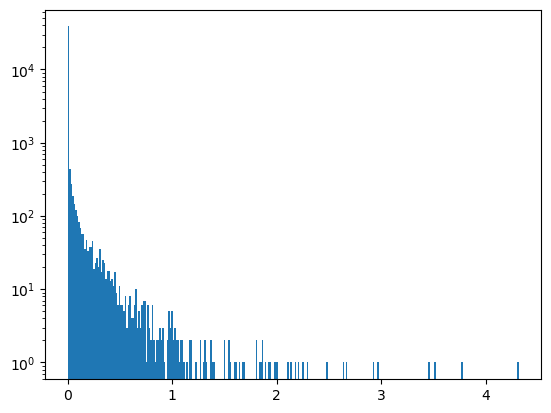


Example 16:
min: 0.0, max: 7.175927639007568
mean: 0.1472674012184143
torch.Size([10, 64, 64])


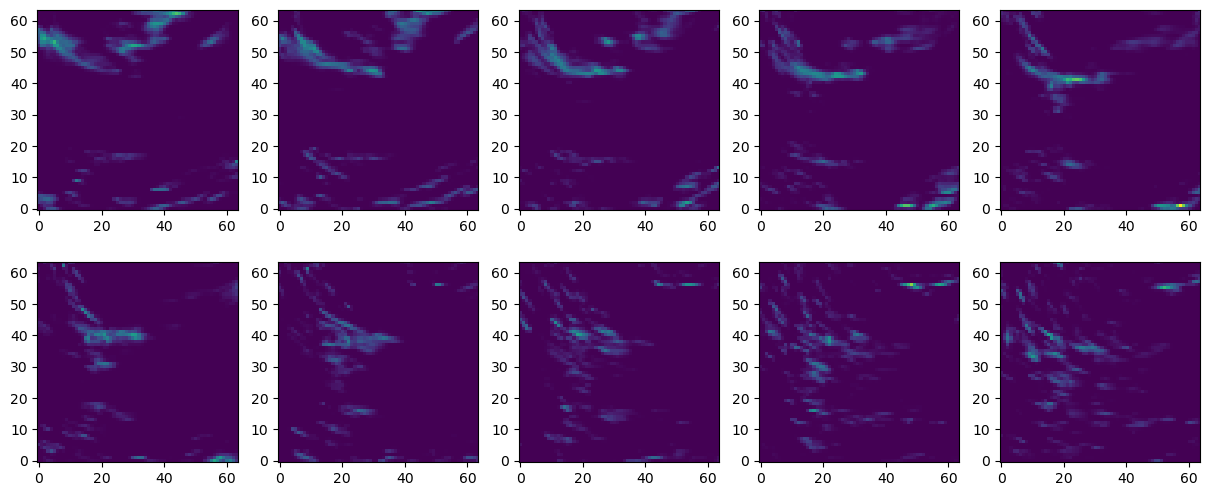

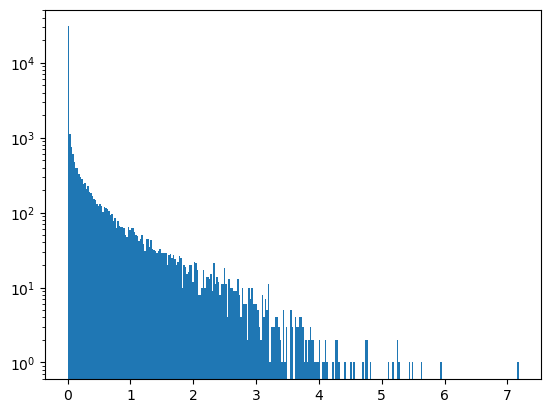


Example 17:
min: 0.0, max: 3.4331412315368652
mean: 0.009336988441646099
torch.Size([10, 64, 64])


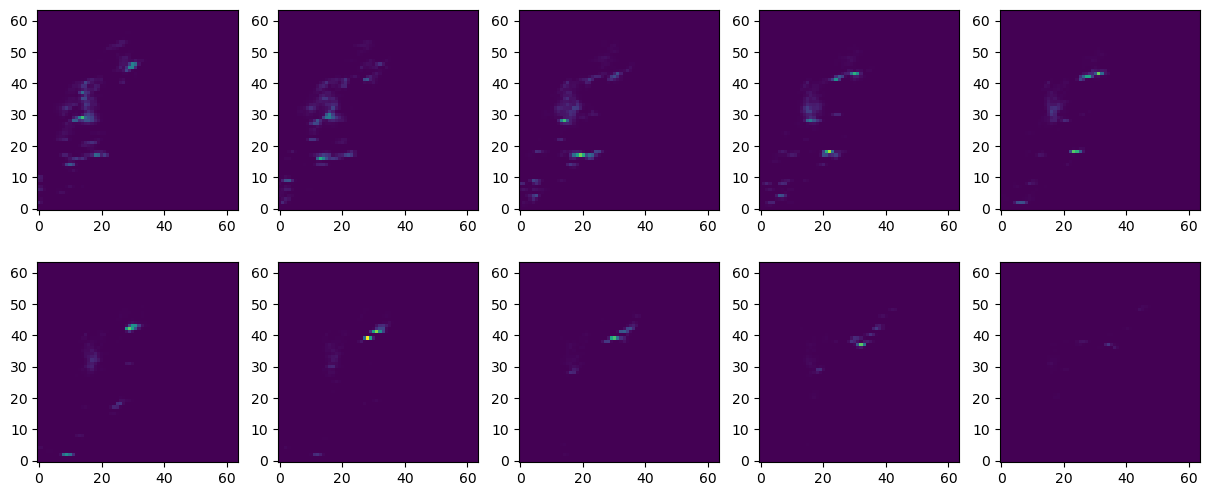

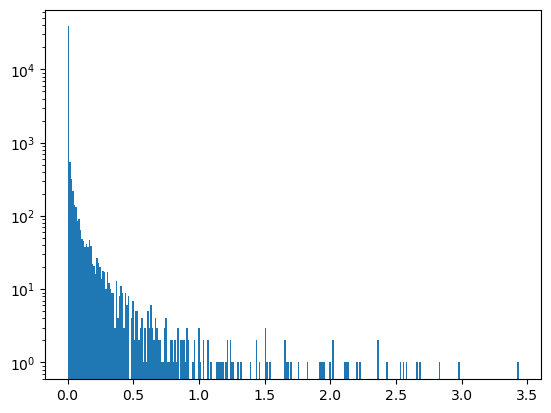


Example 18:
min: 0.0, max: 4.625442028045654
mean: 0.002971522742882371
torch.Size([10, 64, 64])


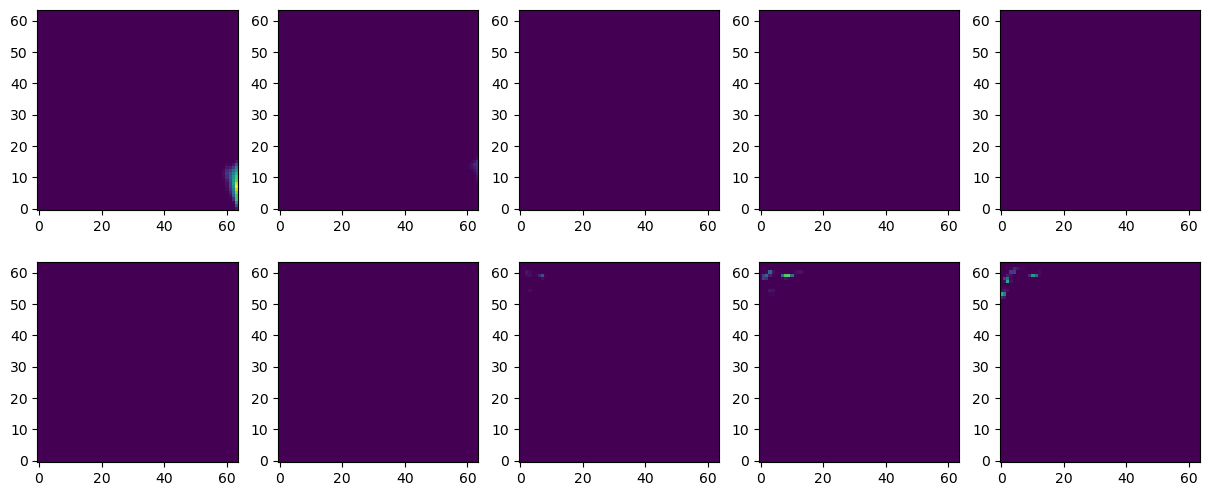

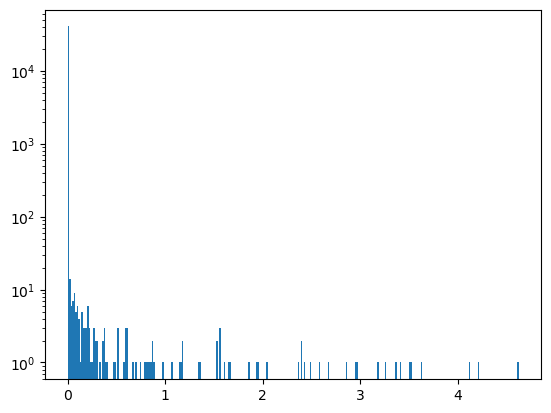


Example 19:
min: 0.0, max: 3.7611796855926514
mean: 0.0635644719004631
torch.Size([10, 64, 64])


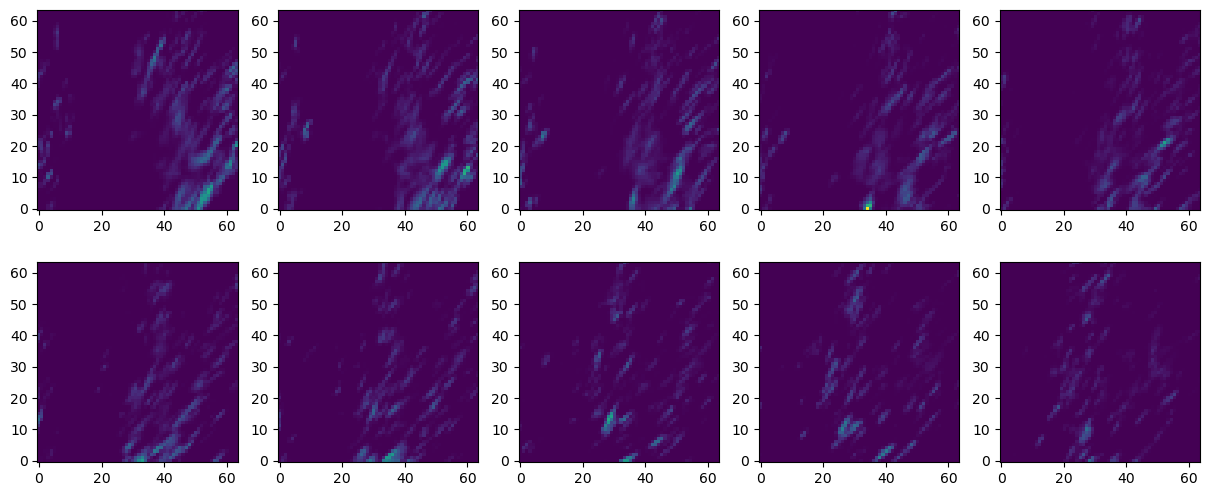

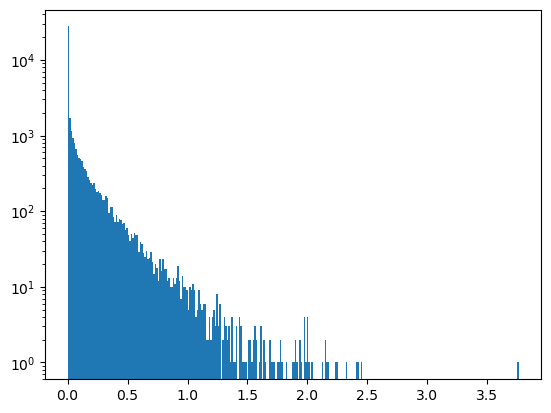


Example 20:
min: 0.0, max: 0.6214540004730225
mean: 0.00042469886830076575
torch.Size([10, 64, 64])


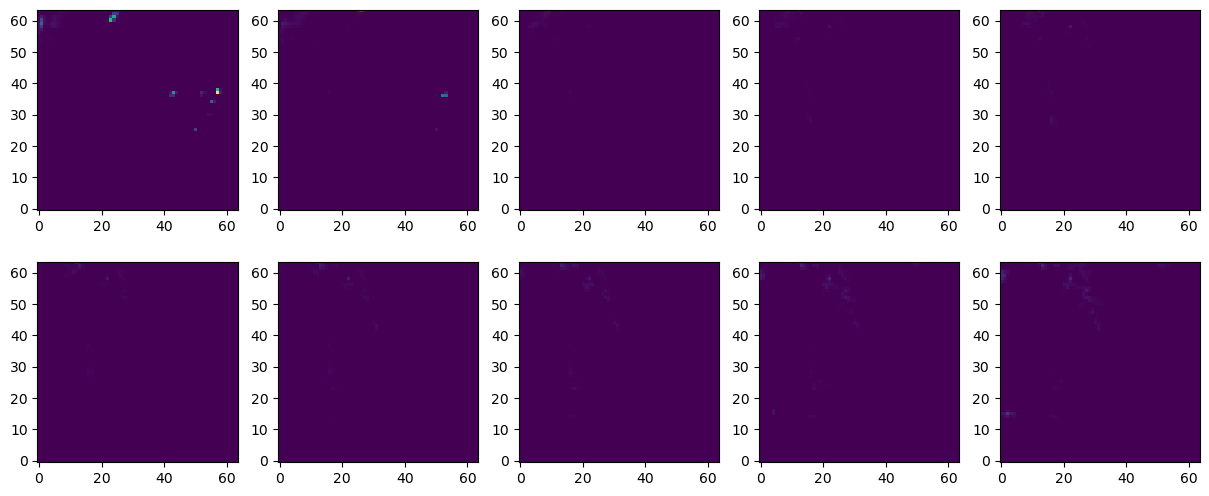

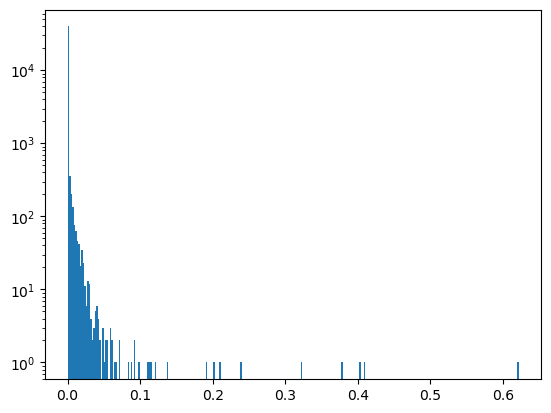


Example 21:
min: 0.0, max: 0.7166868448257446
mean: 0.0005504098371602595
torch.Size([10, 64, 64])


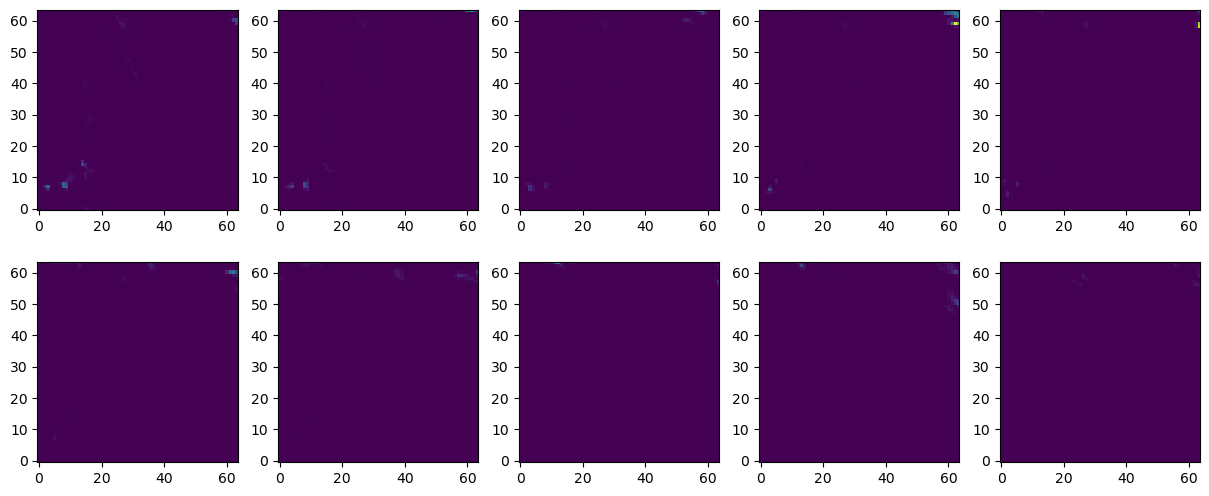

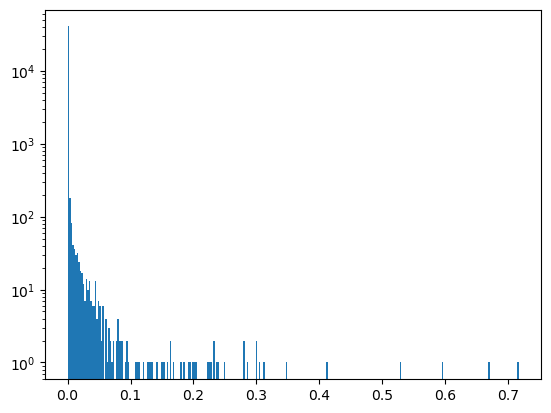


Example 22:
min: 0.0, max: 8.699289321899414
mean: 0.15642058849334717
torch.Size([10, 64, 64])


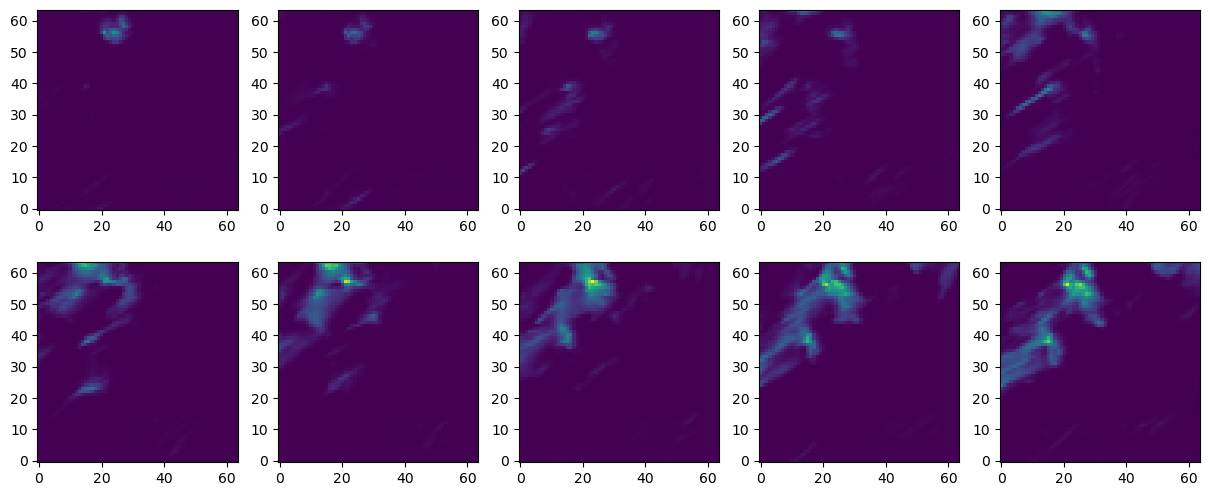

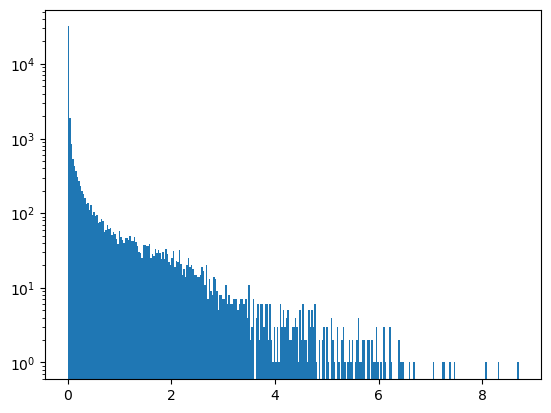


Example 23:
min: 0.0, max: 1.7846662998199463
mean: 0.0004487240803427994
torch.Size([10, 64, 64])


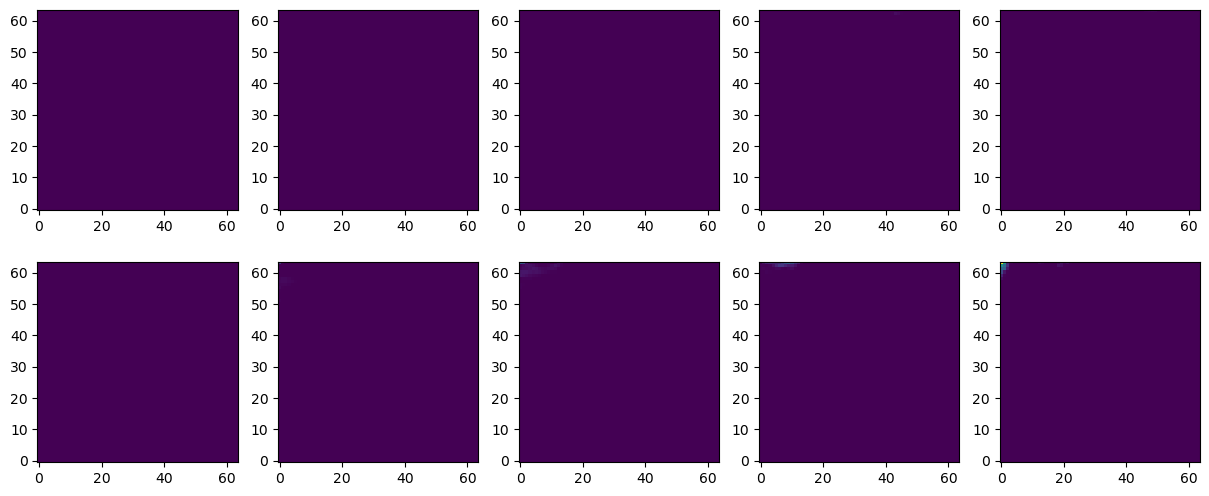

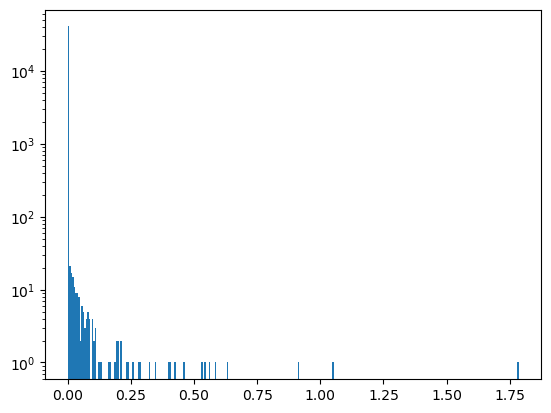


Example 24:
min: 0.0, max: 5.459090232849121
mean: 0.0697517842054367
torch.Size([10, 64, 64])


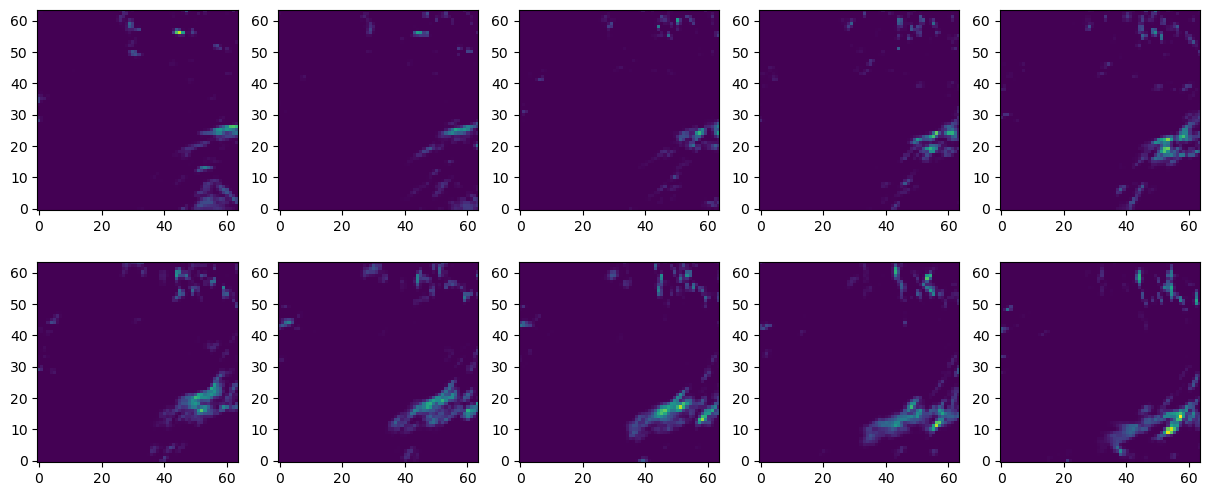

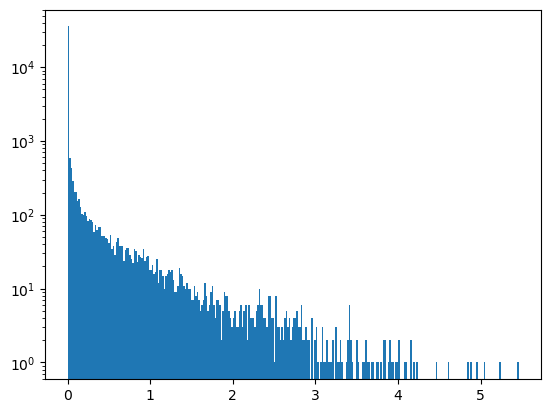


Example 25:
min: 0.0, max: 2.073378086090088
mean: 0.018780484795570374
torch.Size([10, 64, 64])


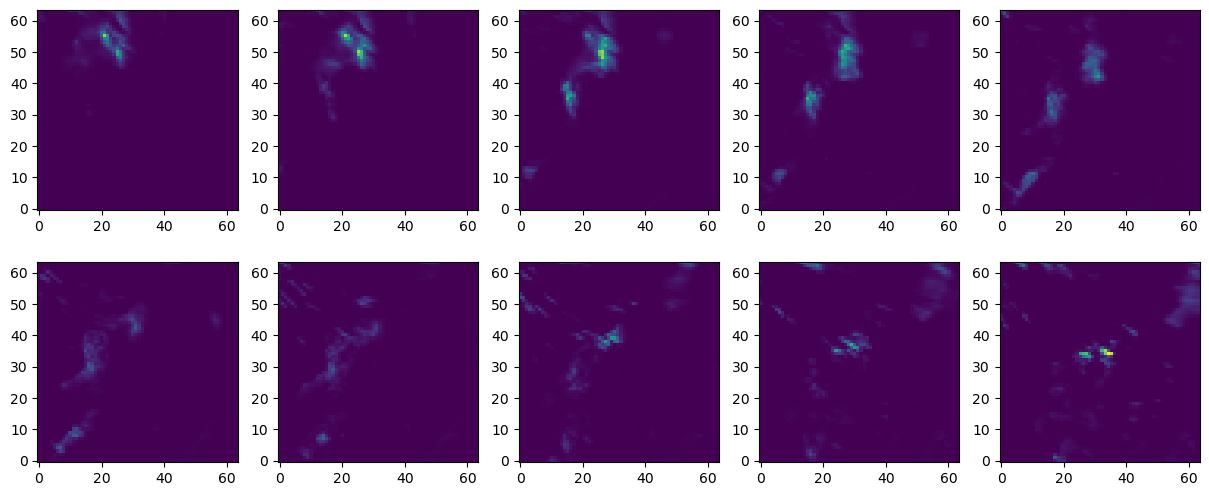

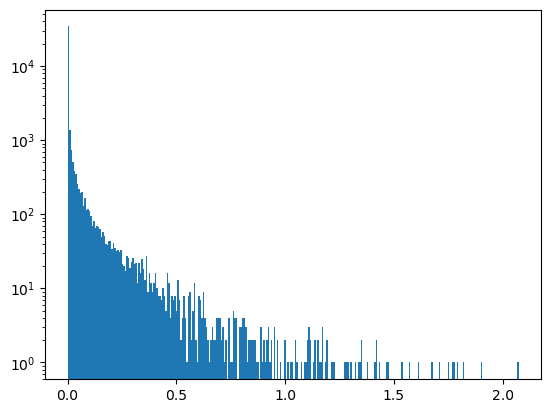


Example 26:
min: 0.0, max: 3.5582809448242188
mean: 0.12028789520263672
torch.Size([10, 64, 64])


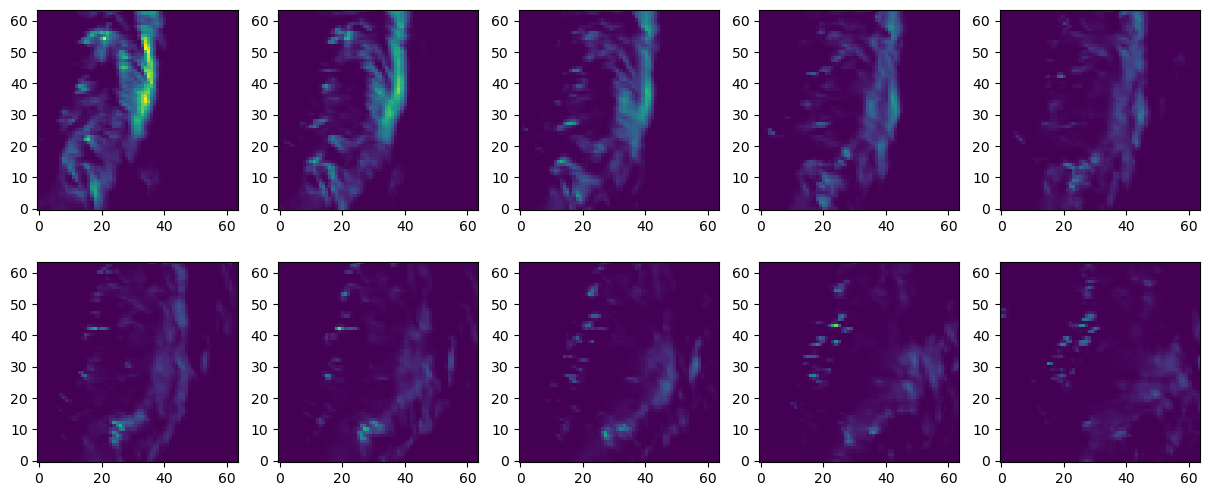

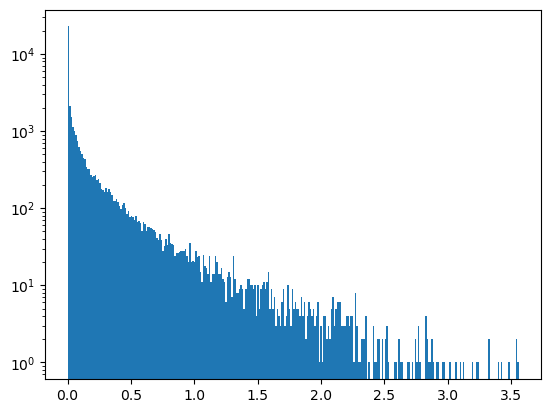


Example 27:
min: 0.0, max: 0.04622756317257881
mean: 7.288874712685356e-06
torch.Size([10, 64, 64])


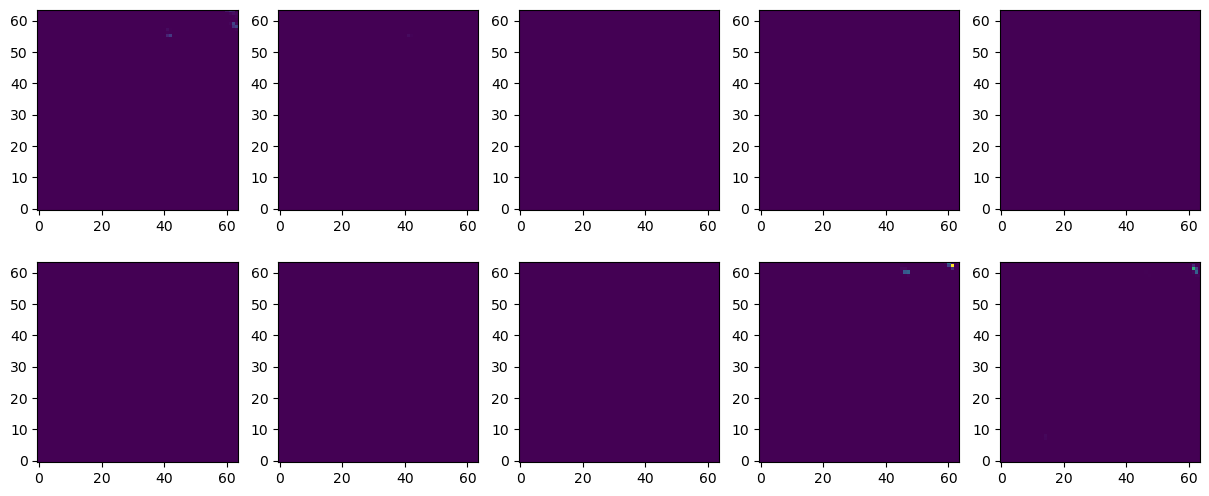

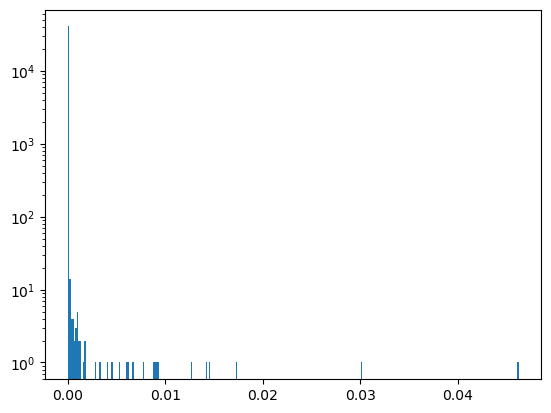


Example 28:
min: 0.0, max: 6.370810508728027
mean: 0.12027955055236816
torch.Size([10, 64, 64])


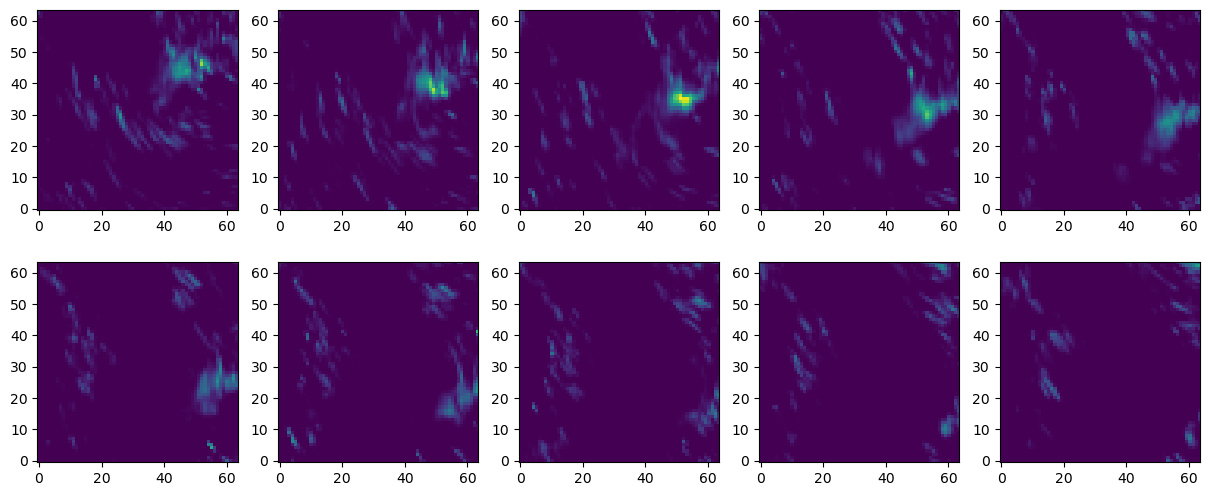

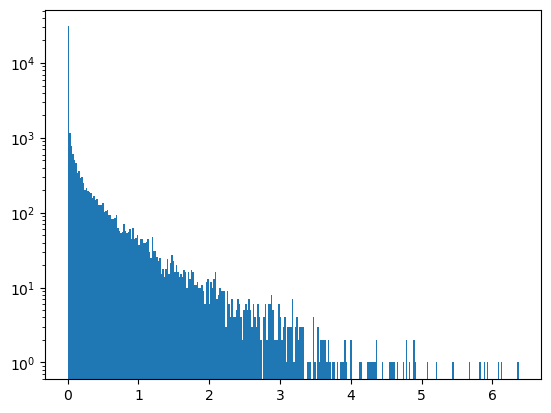


Example 29:
min: 1.2328098819125444e-05, max: 0.2311607301235199
mean: 0.0019520670175552368
torch.Size([10, 64, 64])


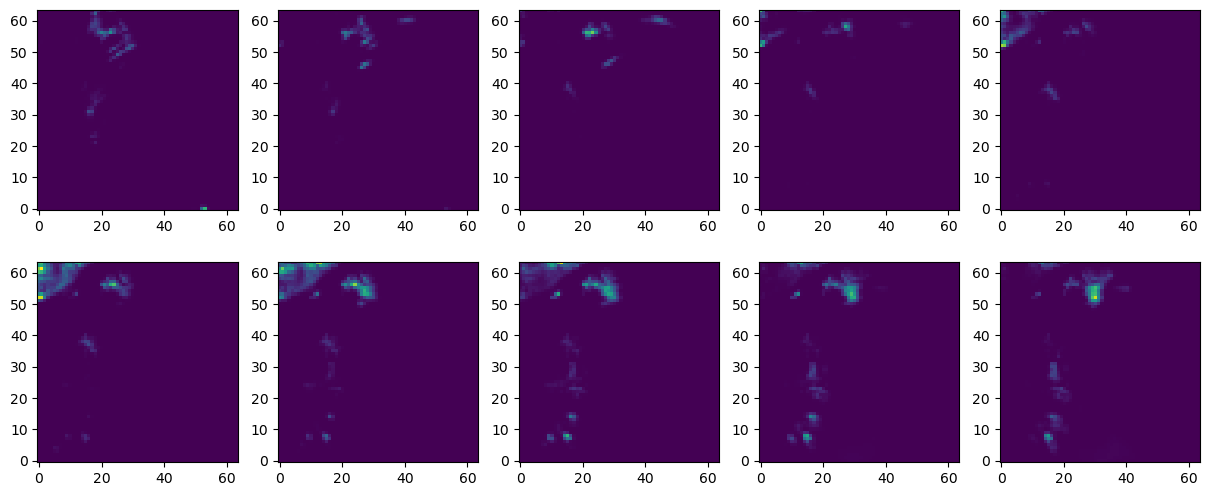

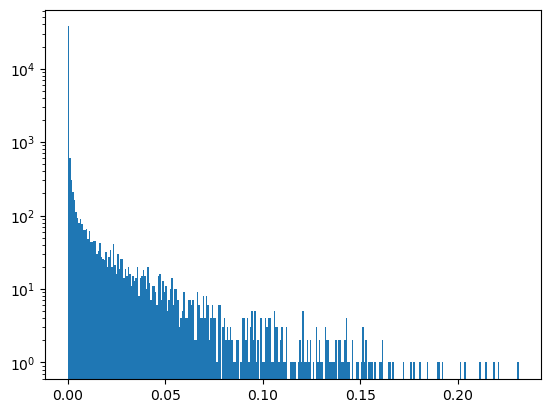


Example 30:
min: 0.0, max: 1.7232295274734497
mean: 0.002682075370103121
torch.Size([10, 64, 64])


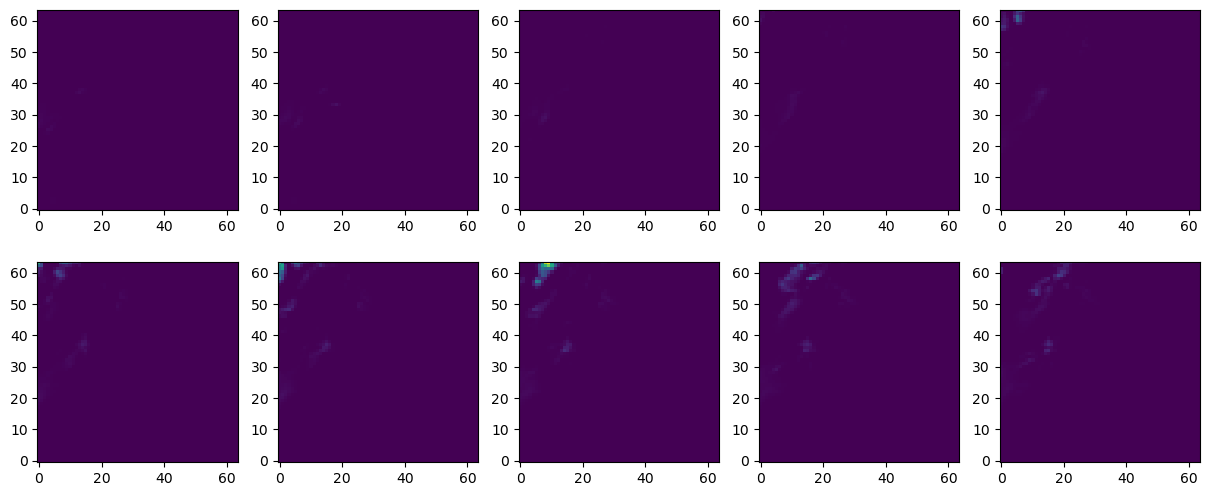

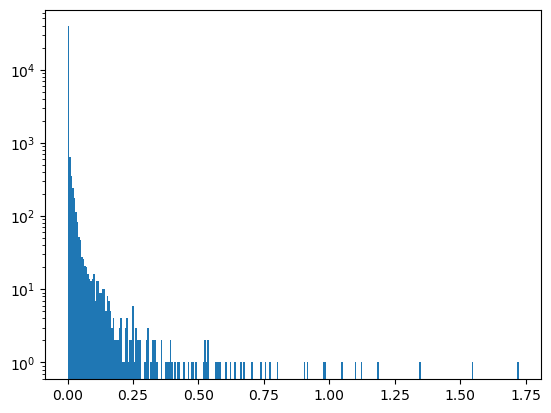


Example 31:
min: 0.0, max: 6.5220046043396
mean: 0.4807802736759186
torch.Size([10, 64, 64])


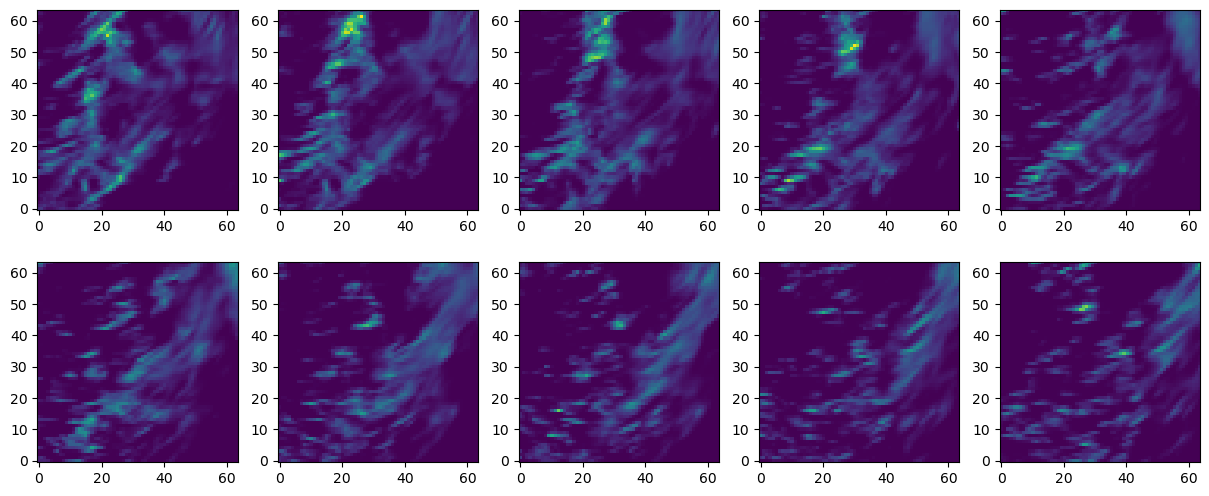

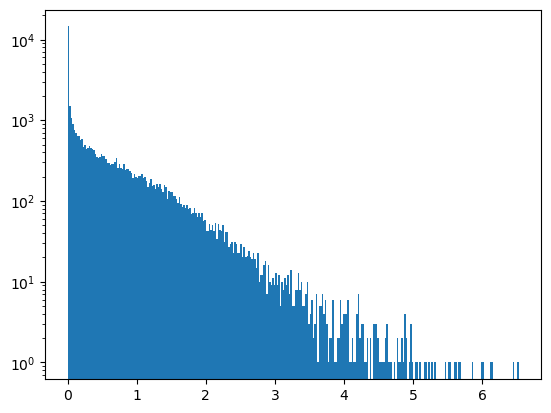


Example 32:
min: 0.0, max: 0.3762955963611603
mean: 0.00012600528134498745
torch.Size([10, 64, 64])


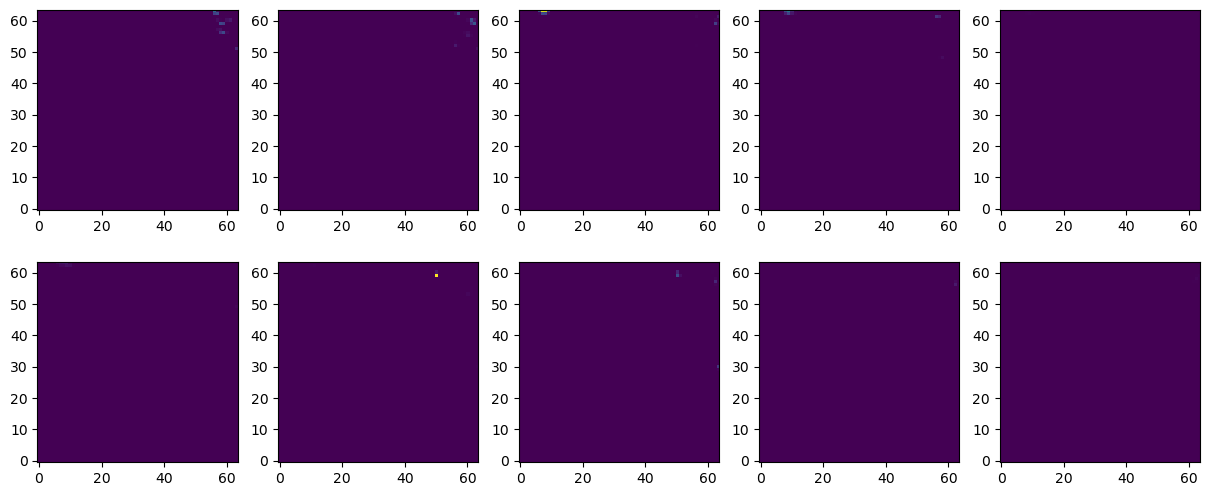

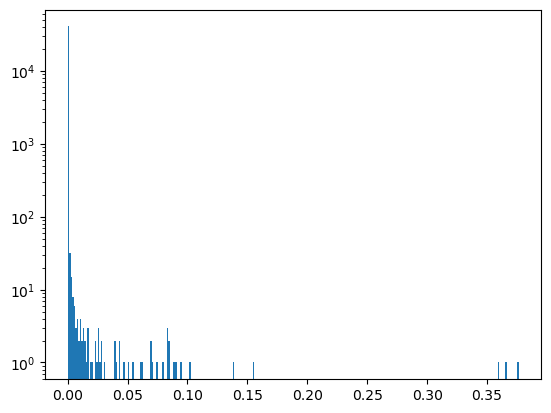


Example 33:
min: 0.0, max: 11.65475845336914
mean: 0.062360476702451706
torch.Size([10, 64, 64])


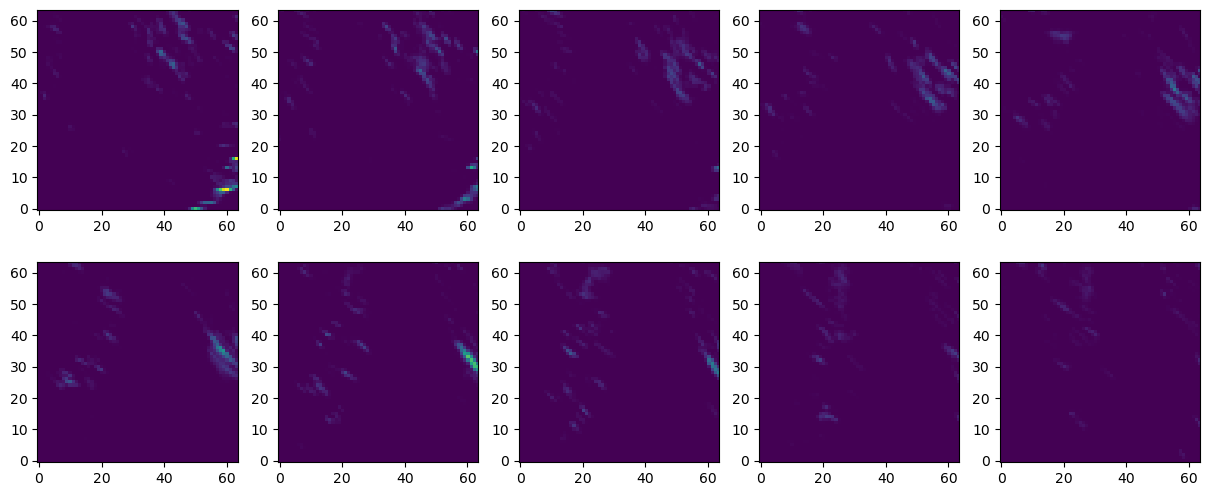

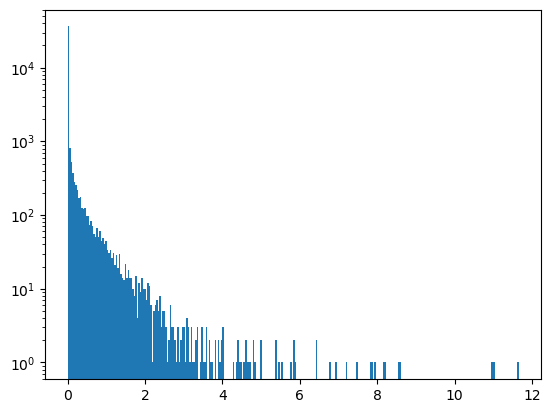


Example 34:
min: 0.0, max: 2.6219818592071533
mean: 0.014683743938803673
torch.Size([10, 64, 64])


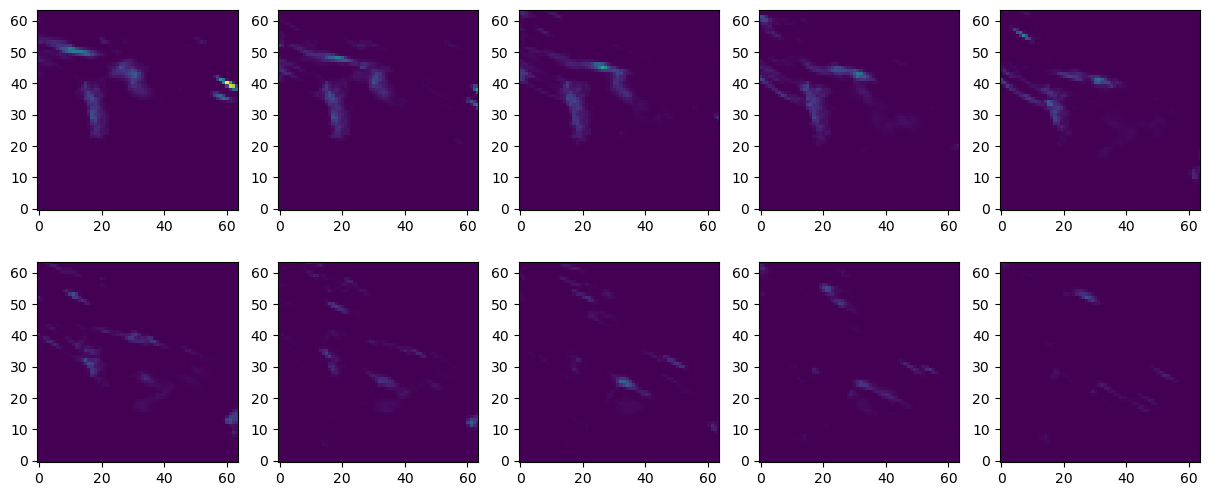

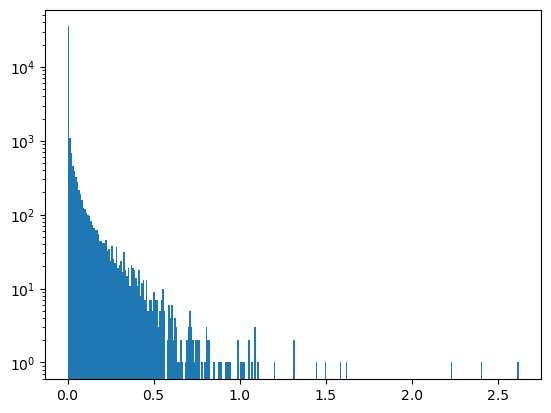


Example 35:
min: 0.0, max: 1.9017592668533325
mean: 0.0014959381660446525
torch.Size([10, 64, 64])


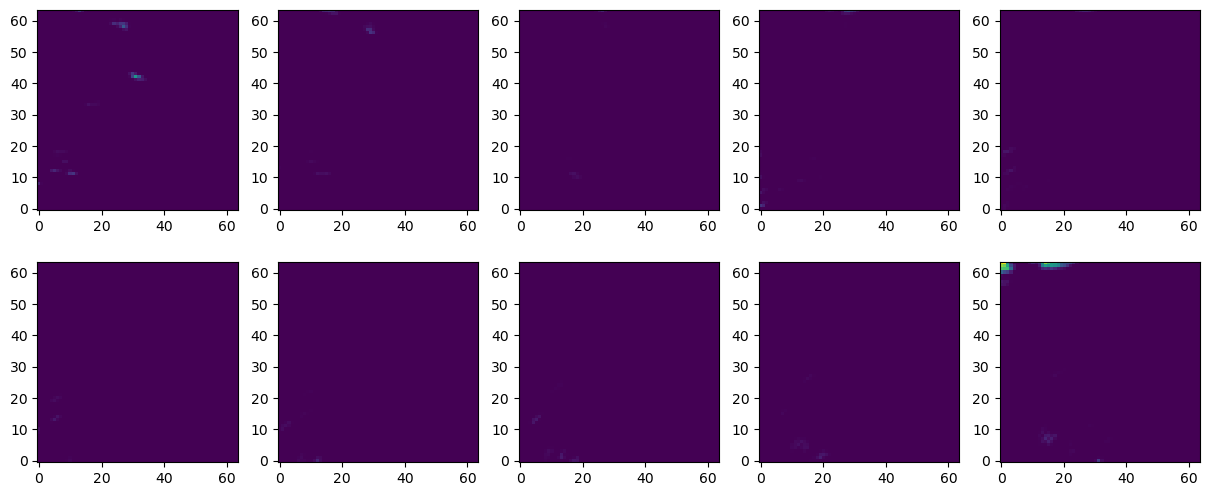

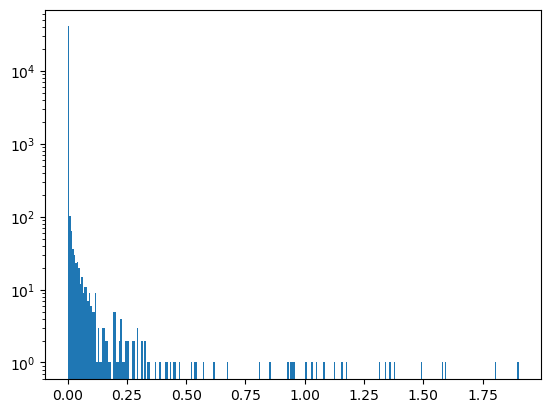


Example 36:
min: 0.0, max: 3.202275276184082
mean: 0.0032183092553168535
torch.Size([10, 64, 64])


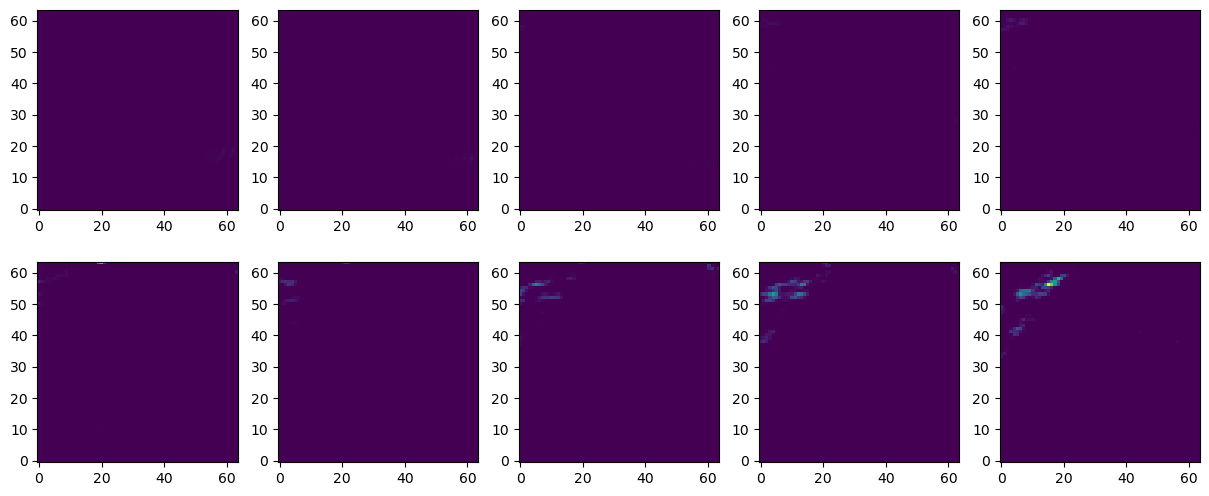

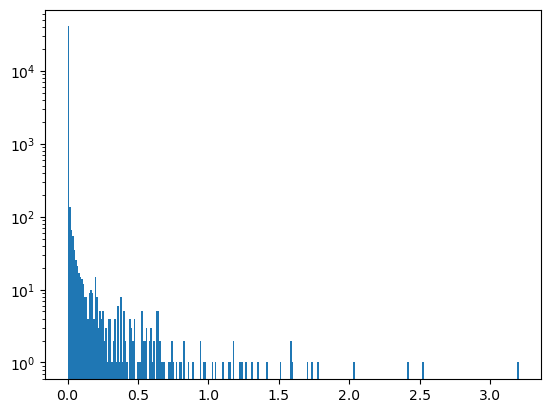


Example 37:
min: 0.0, max: 7.097372531890869
mean: 0.061458516865968704
torch.Size([10, 64, 64])


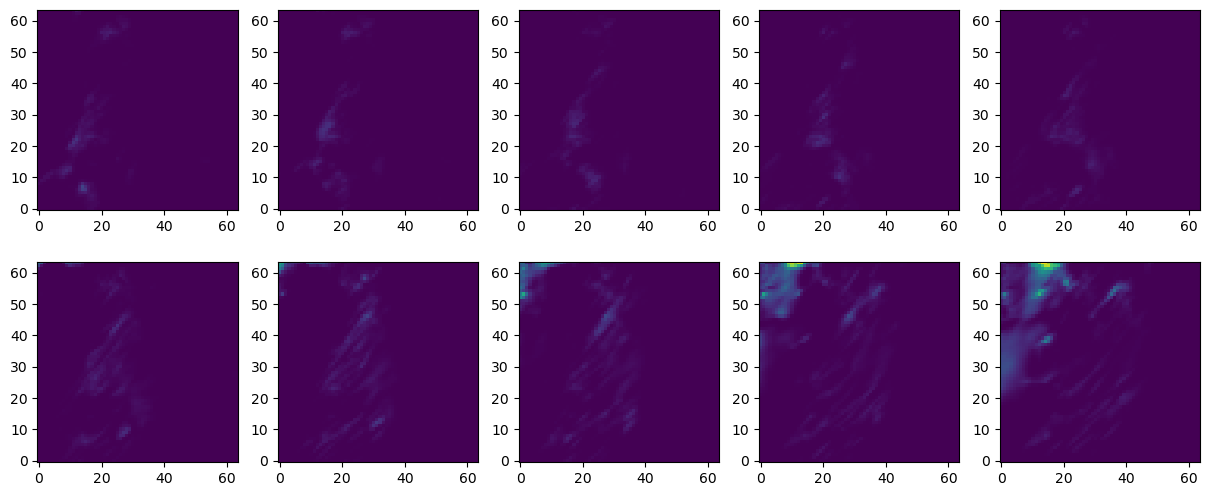

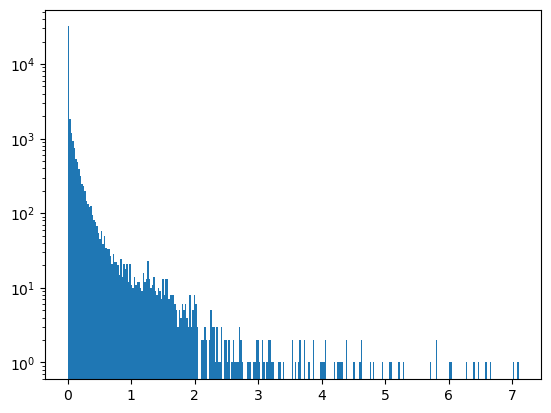


Example 38:
min: 0.0, max: 1.865727186203003
mean: 0.022624250501394272
torch.Size([10, 64, 64])


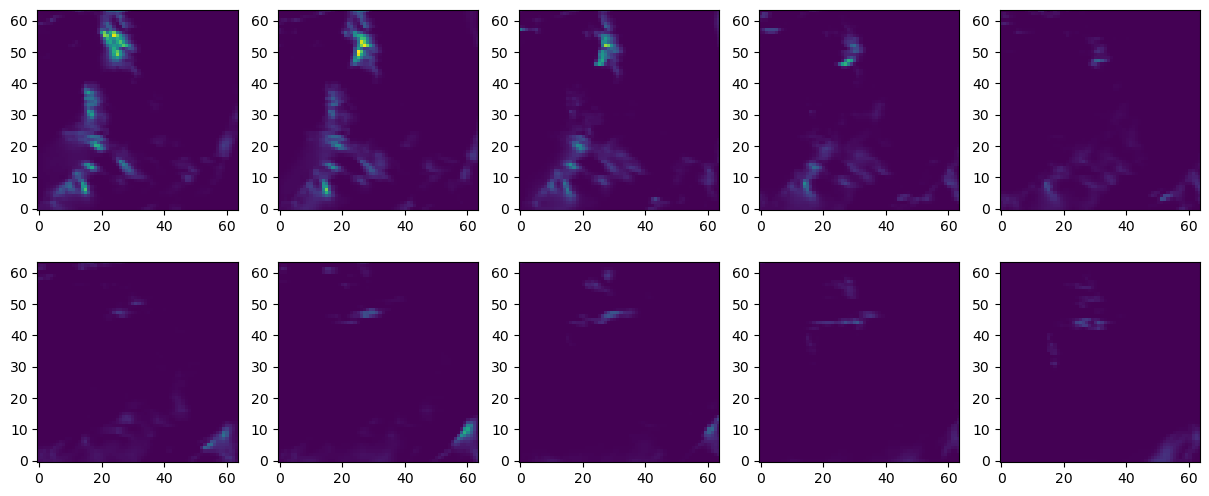

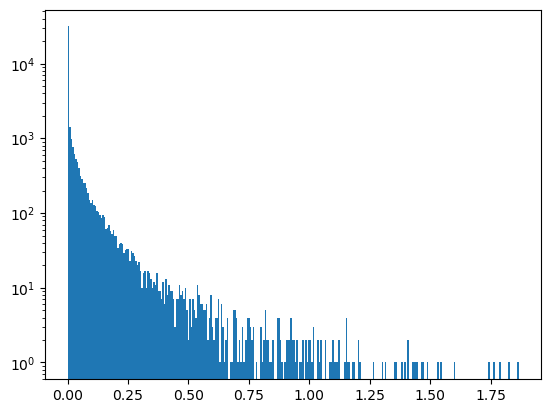


Example 39:
min: 0.0, max: 2.7059264183044434
mean: 0.0036551777739077806
torch.Size([10, 64, 64])


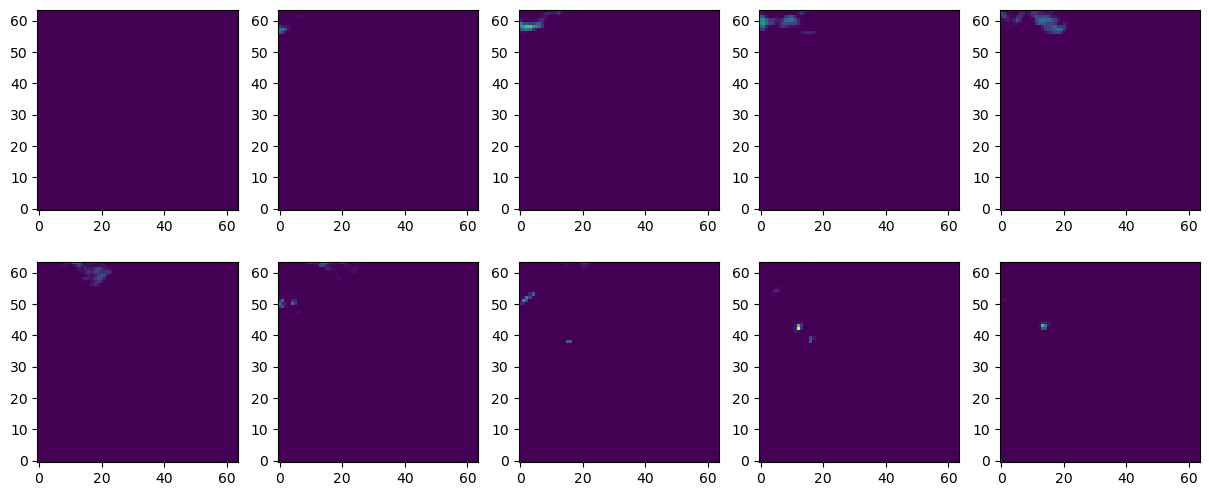

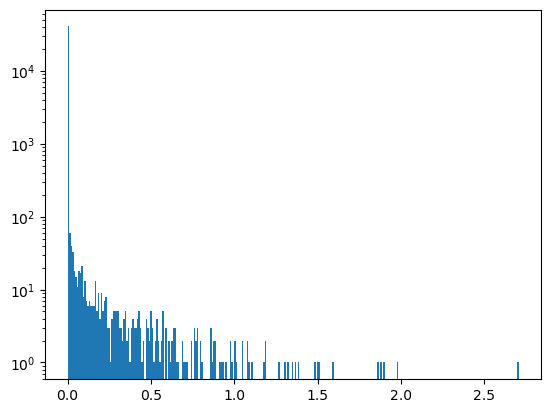


Example 40:
min: 0.0, max: 6.71225118637085
mean: 0.39860695600509644
torch.Size([10, 64, 64])


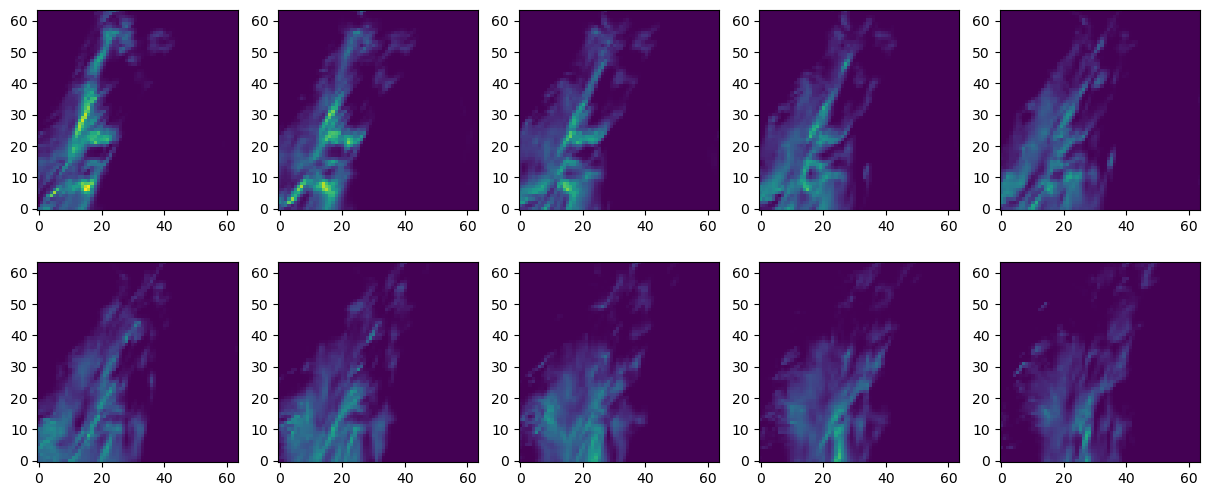

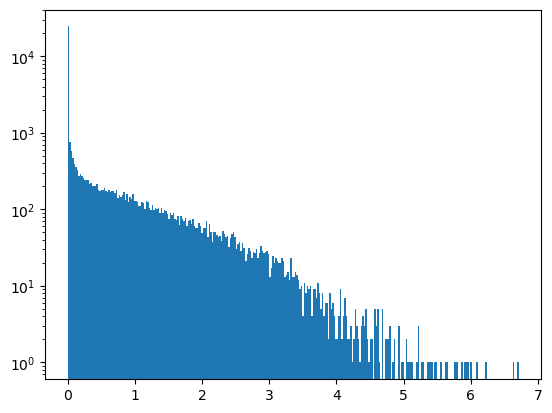


Example 41:
min: 0.0, max: 2.9429683685302734
mean: 0.008297057822346687
torch.Size([10, 64, 64])


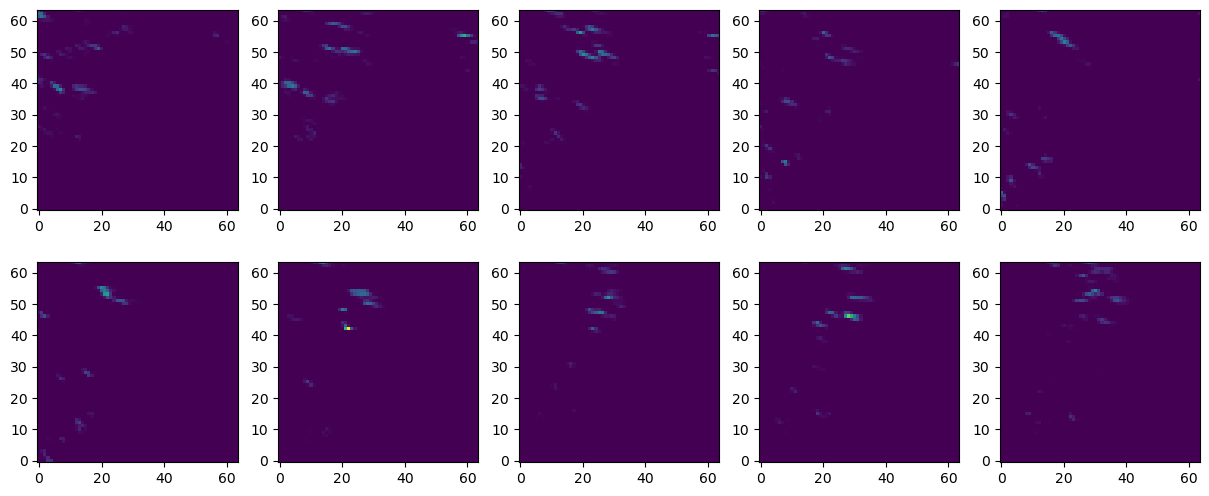

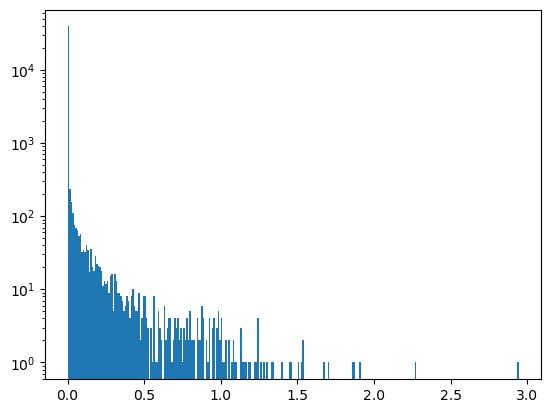


Example 42:
min: 0.0, max: 9.047313690185547
mean: 0.3136996626853943
torch.Size([10, 64, 64])


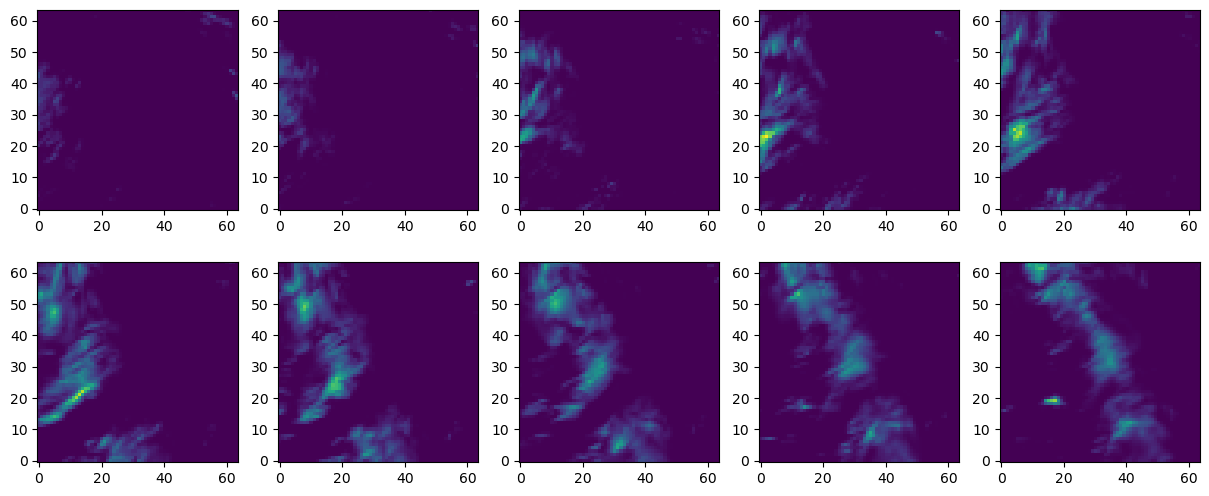

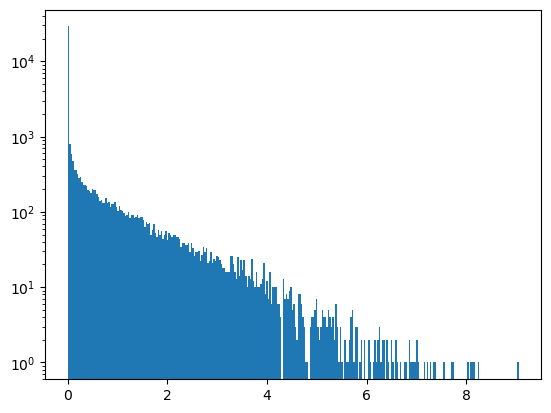


Example 43:
min: 1.7757309251464903e-05, max: 0.49896058440208435
mean: 0.0004149755113758147
torch.Size([10, 64, 64])


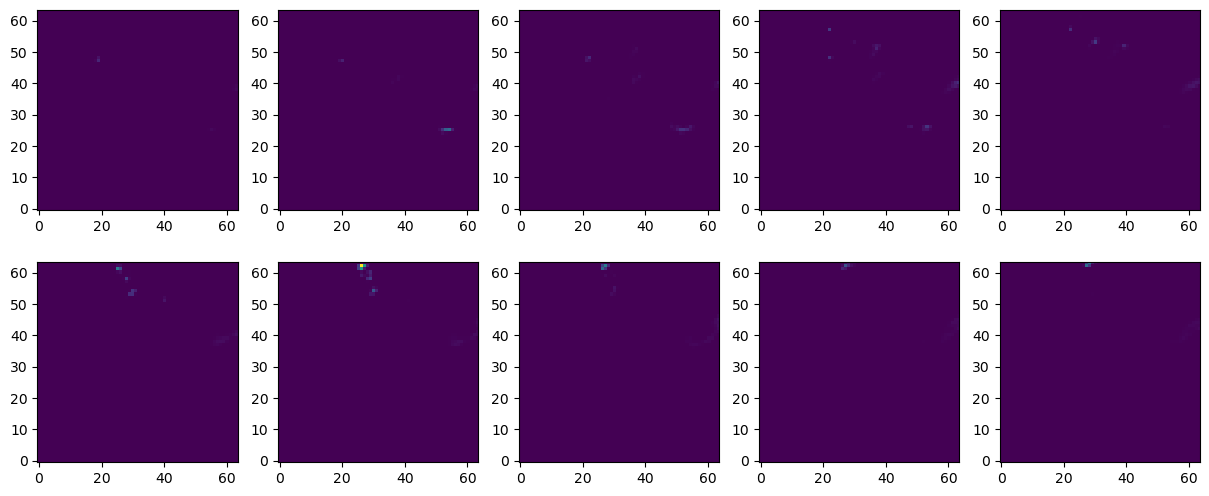

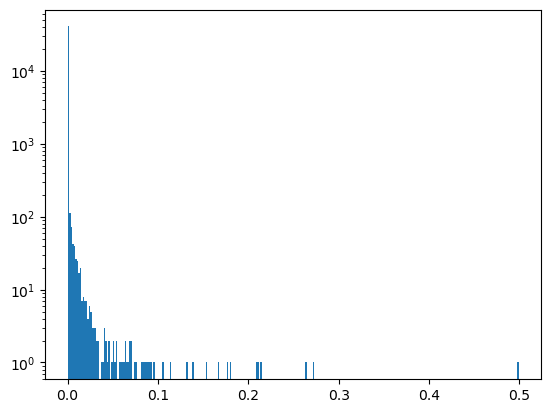


Example 44:
min: 2.8922448109369725e-05, max: 4.783219337463379
mean: 0.049171172082424164
torch.Size([10, 64, 64])


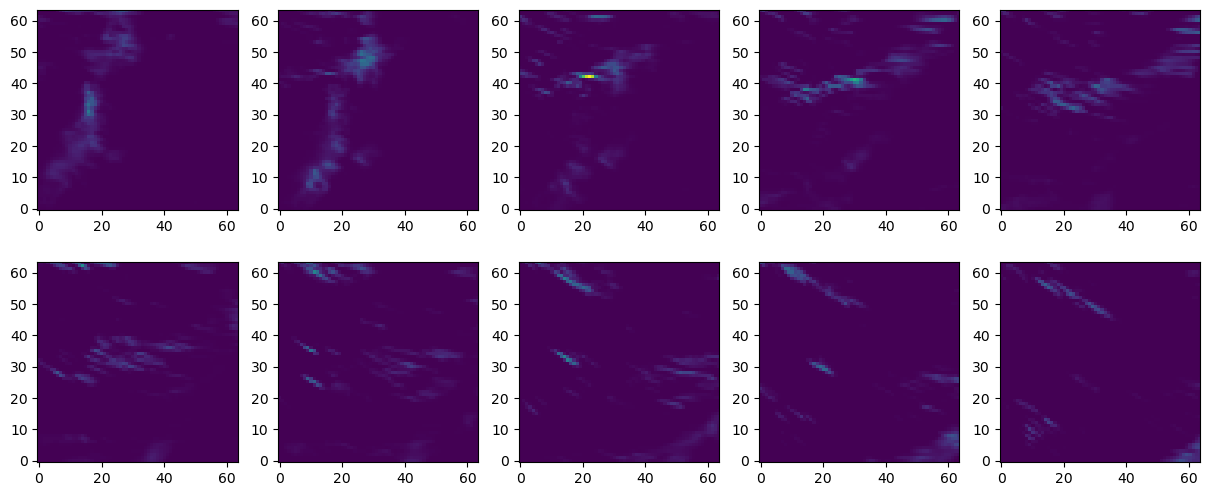

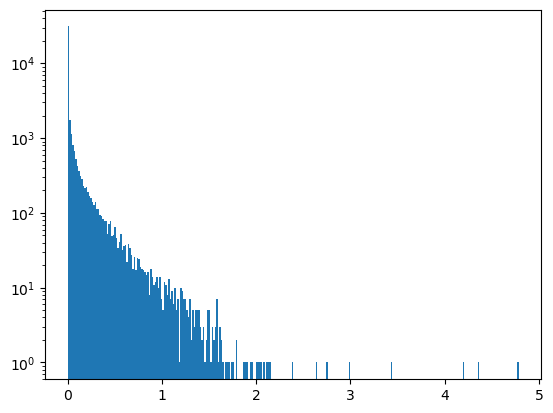


Example 45:
min: 0.0, max: 8.841729164123535
mean: 0.25329023599624634
torch.Size([10, 64, 64])


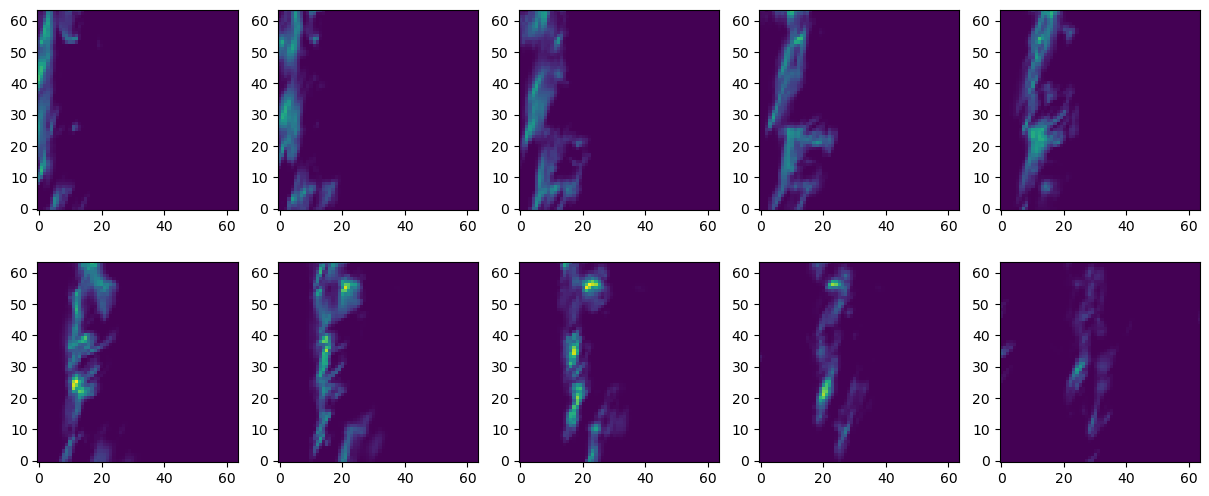

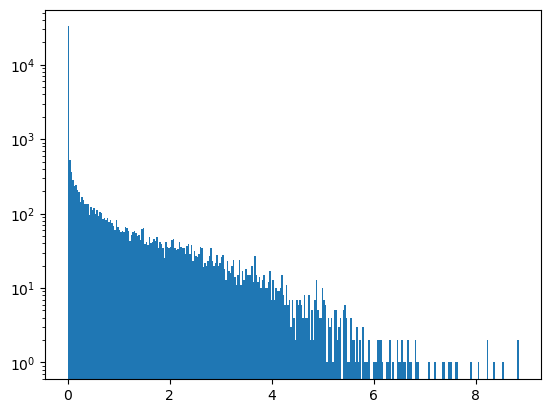


Example 46:
min: 0.0, max: 5.242496013641357
mean: 0.05542612820863724
torch.Size([10, 64, 64])


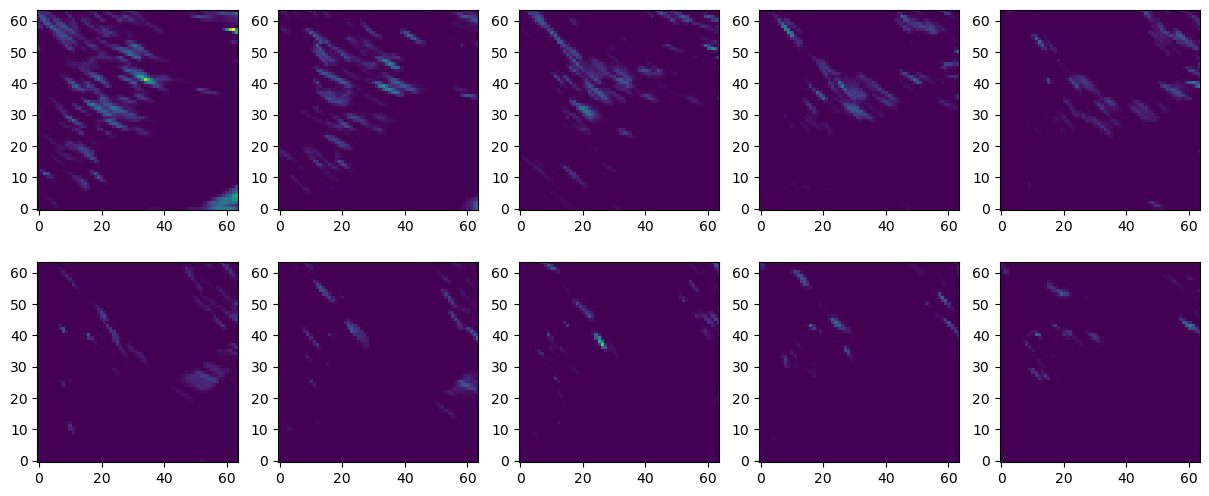

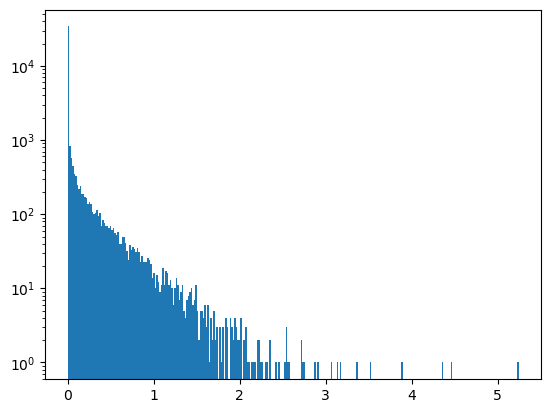


Example 47:
min: 0.0, max: 11.79196834564209
mean: 0.02863256260752678
torch.Size([10, 64, 64])


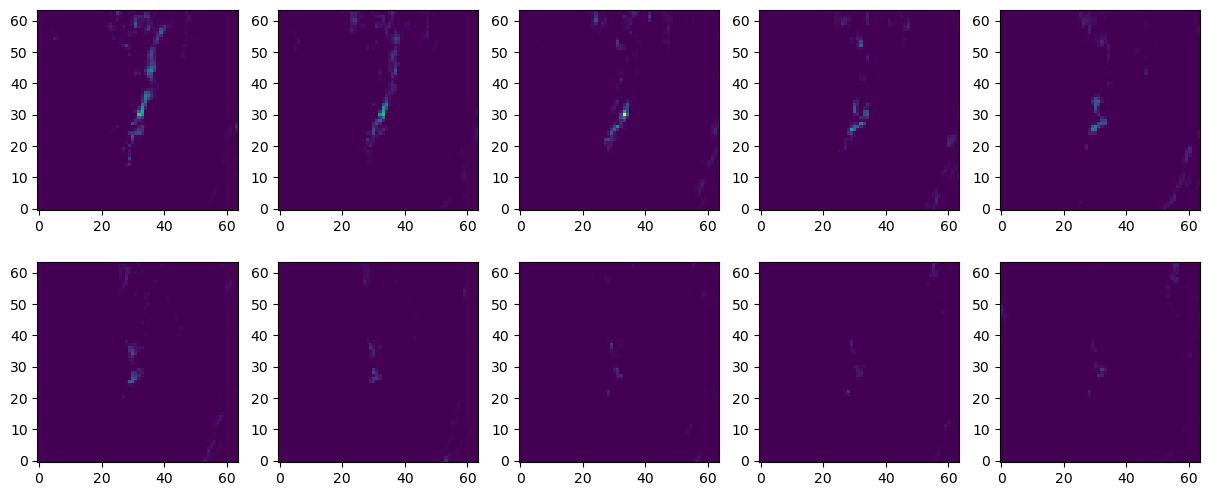

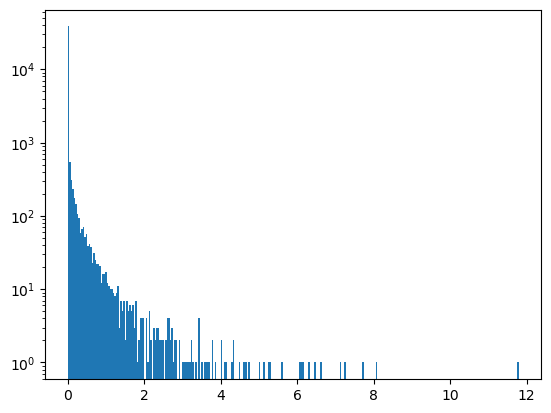


Example 48:
min: 0.0, max: 4.708226680755615
mean: 0.06455592811107635
torch.Size([10, 64, 64])


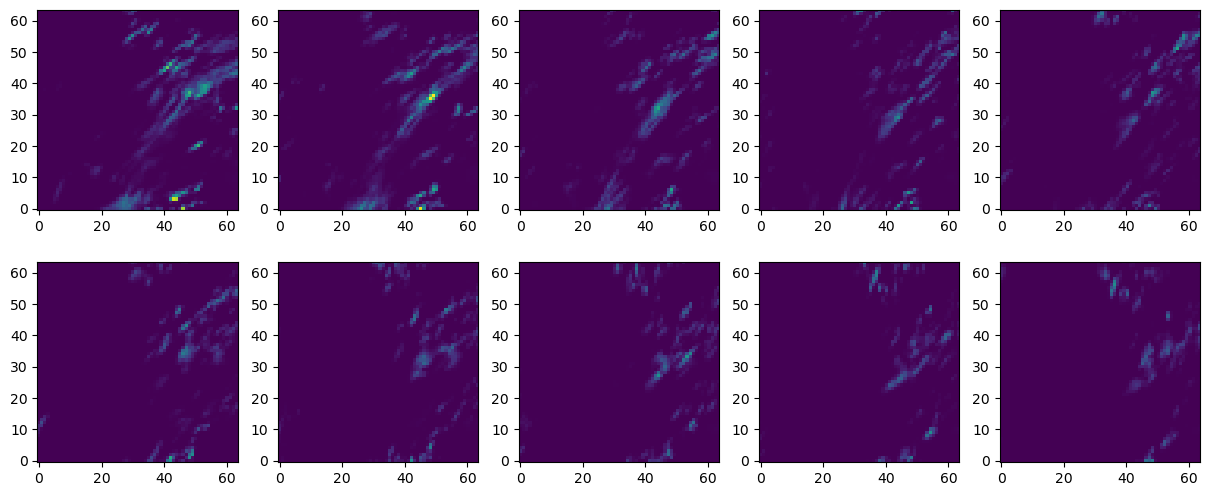

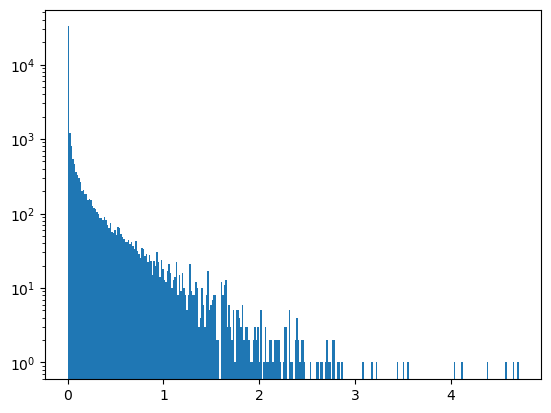


Example 49:
min: 0.0, max: 3.314249277114868
mean: 0.002511207479983568
torch.Size([10, 64, 64])


In [81]:
# ds = torch.load("results/results_16r/20.pt", map_location=torch.device('cpu'))
# ds = torch.load("results/results_2r/70.pt", map_location=torch.device('cpu'))
# ds = torch.load("results/results_2r_dyn/50.pt", map_location=torch.device('cpu'))
# ds = torch.load("results/results_4r/52.pt", map_location=torch.device('cpu'))
# ds = torch.load("results/results_8r/52.pt", map_location=torch.device('cpu'))

# ds = torch.load("results/results_2r/70.pt", map_location=torch.device('cpu'))
# ds = torch.load("results/results_2r_l2/78.pt", map_location=torch.device('cpu'))
# ds = torch.load("78.pt", map_location=torch.device('cpu'))
ds = torch.load("samples.pt", map_location=torch.device('cpu'))

# all_values = ds.flatten()
# plt.hist(np.log10(all_values + 1e-8), bins = 300)
# plt.show()

for i in range(1024):
    ex = ds[i][0]
    print(f"\nExample {i}:")
    print(f"min: {ex.min()}, max: {ex.max()}\nmean: {ex.mean()}")
    print(ex.shape)
    fig, axs = plt.subplots(2, 5, figsize = (15, 6))
    for j in range(10):
        ax = axs.flat[j]
        frame = ex[j]
        ax.imshow(frame, origin = "lower", vmin = ex.min(), vmax = ex.max())
    plt.show()

    plt.hist(ex.flatten(), bins = 300)
    plt.yscale("log")
    plt.show()